# Range expansion shifts clonal interference patterns in evolving populations

Here we present code to run simulations and generate the figures seen in our pre-print: __Nikhil Krishnan and Jacob G. Scott. Range expansion shifts clonal interference patterns in evolving populations. bioRxiv (2019). 794867__  

Additionally, we will illustrate key concepts with additional figures not included in the manuscript, which will be indicated as such

## Prerequisites

In [1]:
###computation
import numpy as np
from numpy import gradient as grad
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import glob
import os


#visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import rcParams
from matplotlib.lines import Line2D

from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from itertools import product

import pandas as pd
import seaborn as sns

#custom fu
from stepping_stone_funcs import*


##for improved readability of markdown
#import warnings
#warnings.filterwarnings('ignore')


#### Matplotlib settings

In [145]:
from matplotlib import rcParams
from matplotlib import rc
rcParams["mathtext.fontset"] = "dejavuserif"
rcParams['font.family'] = 'serif'


## Clonal interference in a well mixed model

We invoke the analysis of Desai et. al. (2007, https://doi.org/10.1534/genetics.106.067678), to illustrate the stochastic effects of genetic drift on the survival of beneficial mutants, and the deterministic limits of these effects. Here we will elucidate essential assumptions and the reasons for them which we hope readers not yet familiar with theoretical population genetics literature will find instructive.

We model the survival of a beneficial mutant as a stochastic branching process, to capture the impact of genetic drift at early times. In order to this, we assume a population of a large, fixed size $N$, with a large number of beneficial muations, acquired at rate $U_b$, each of which increases fitness by a value $s$. 

In regard to the magnitude of N, it is particularly important $Ns>>1$, so that as the mutant population grows sufficinelty large, stohcastic effects can be ignored, and the deterministic limit can be treated simply. The constraint that N is fixed, is a simplyifying one that can be relaxed without change to the essential dynamics in many contexts (Kimura & Ohta 1974 https://doi.org/10.1073/pnas.71.9.3377)

We consider the fate of a single beneficial mutant arising at time $t=0$ with fitness 1+s. The rest of the population has an average birth rate of 1 and death rate of 1. We obtain for $g(n,n_0,t)$, the probability of having $n$ decescendents with $n_0$ descendants at time $t$.

We find from deduction, $g(n,1,t) = \frac{1}{2+s}(2+S)dt\delta_{n,0} +\frac{1+s}{2+s}(2+S)dtg(n,2,t-dt)+[1-(2+s)dt]g(n,1,t-dt)$

F:rom the above equation one can derive a prboability generating ewation, $p(n,t)$ for the number of $n$ descendants at time $t$ from 1 initial decescemt: $p(n,t) = \frac{s^2 e^{st}}{[(1+s)e^{st}-1][(1+s)e^{st}-1-s]} x [\frac{(1+s)e^{st}-1-s}{(1+s)e^{st}-1}]^n  \quad{\mathrm{for} } \quad{n>0} \quad{\mathrm{and}}$ $p(n=0,t) = \frac{e^{st}-1}{(1+s)e^{st}-1}$

We note that the extinction probability saturates at $\sim s$, consistent with classic results (Haldane, 1927). From here, we find from the above probability, the expected mutant population size at time t contigent on non-extinction:

$\langle n|n\neq0\rangle = e^{st} + \frac{e^{st}-1}{s}$. At long times ($t>>1/s$), $\langle n|n\neq0\rangle \approx  \frac{e^{st}}{s}$, and so the time at which  $n \sim N$, or the fixation time $\langle \tau_{fix} \rangle$ is:

$\langle \tau_{fix} \rangle \approx \frac{1}{s}\log(Ns)$ and $\langle \tau_{est} \rangle \approx 1/NU_bs $

The above expressions lend to a heuristic argument for the constratins on the mutation-limited evolutionary regime, which occurs when the average time for mutation establishment greatly exceeds the average time for fixation:

$NU_b\log(Ns)<<1$

### Box 1 Figures

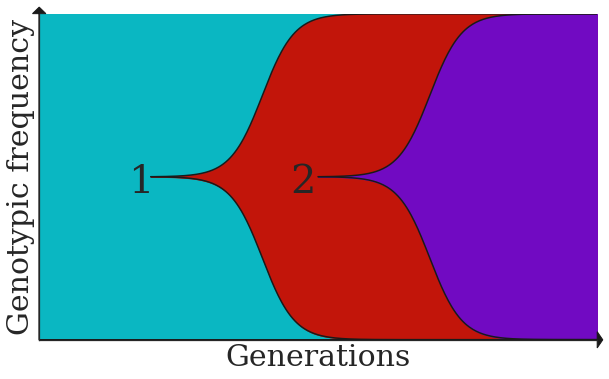

In [2112]:
##Box 1 Figure (left)
fig, ax = plt.subplots(figsize=(10,6))
##assign colors


wt= [sns.hls_palette(8, l=.4, s=.9)[4]]
mut = [sns.hls_palette(8, l=.4, s=.9)[0]]
mut1 = [sns.hls_palette(8, l=.4, s=.9)[-2]]


##clone 0
ax.fill_between(np.linspace(0,500,500),.5,-.5,color = wt)

##clone 1
clone = (.5/(1+np.exp(-.07*np.linspace(0,400,400)+7))) - .5/(1+np.exp(7))
clone_ = -clone
ax.plot(np.linspace(100,500,400),clone,'k')
ax.plot(np.linspace(100,500,400),clone_,'k')
ax.fill_between(np.linspace(100,500,400),clone,clone_,color = mut) ##fill boundaries for first mutant 

##clone 2 
clone2 = (.5/(1+np.exp(-.07*np.linspace(0,250,250)+7))) - .5/(1+np.exp(7))
clone2_ = -clone2
ax.fill_between(np.linspace(250,500,250),clone2,clone2_,color = mut1) ##fill boundaries for second mutant 
ax.plot(np.linspace(250,500,250),clone2,'k')
ax.plot(np.linspace(250,500,250),clone2_,'k')

##adjust plot
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-.5,.5)
ax.set_xlim(0,500)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('Genotypic frequency',fontsize=30)
ax.set_xlabel('Generations',fontsize=30)
ax.text(80,-.05,'1',fontsize=40)
ax.text(225,-.05,'2',fontsize=40)

##add arrows on axes
ax.arrow(0,-.5,500,0,head_width =.05,head_length= 5,clip_on=False,color = 'k')
ax.arrow(0,-.5,0,1,head_width =12,head_length= .02,clip_on=False,color = 'k')
ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)
plt.savefig('SSWM.pdf', facecolor=ax.get_facecolor(), edgecolor='none'  )

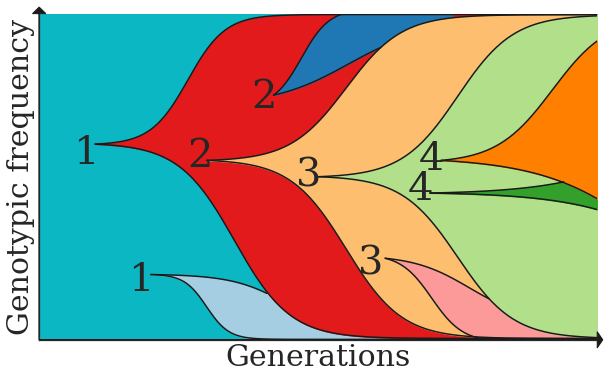

In [2113]:
##Box 1 Figure (Right)
fig, ax = plt.subplots(figsize=(10,6))

##mutant colors 
pal = sns.color_palette("Paired",10) ##mutant colors
ls = 40 ##line label font size 


#clone 0
ax.fill_between(np.linspace(0,500,500),.5,-.5,color = wt)


#clone 1b
clone1b = -((.2/(1+np.exp(-.04*np.linspace(0,400,400)+5))) - (.2/(1+np.exp(5)))+.3)
clone1b_ = -((.2/(1+np.exp(-.1*np.linspace(0,400,400)+5))) - (.2/(1+np.exp(5)))+.3)
ax.fill_between(np.linspace(100,500,400),clone1b,clone1b_,color = [pal[0]])
ax.plot(np.linspace(100,204,104),clone1b[0:104],'k')
ax.plot(np.linspace(100,500,400),clone1b_,'k')
ax.text(80,-.35,'1',fontsize=ls) ##label 

#clone 1a
clone1a = (.4/(1+np.exp(-.06*np.linspace(0,450,450)+5))) - .4/(1+np.exp(5)) +.1
clone1a_ = -((.6/(1+np.exp(-.04*np.linspace(0,450,450)+5))) - .6/(1+np.exp(5)) -.1)
ax.fill_between(np.linspace(50,500,450),clone1a,clone1a_,color = [pal[5]])
ax.plot(np.linspace(50,500,450),clone1a,'k')
ax.plot(np.linspace(50,500,450),clone1a_,'k')
ax.text(30,.04,'1',fontsize=ls) ##label


#clone 2b
clone2b = (.30/(1+np.exp(-.08*np.linspace(0,160,160)+2))) - (.30/(1+np.exp(2)))+.25
clone2b_ =(.25/(1+np.exp(-.03*np.linspace(0,160,160)+2))) - (.25/(1+np.exp(2)))+.25
ax.fill_between(np.linspace(210,370,160),clone2b_,clone2b,color = [pal[1]])
ax.plot(np.linspace(210,370,160),clone2b,'k')
ax.plot(np.linspace(210,306,96),clone2b_[0:96],'k')
ax.text(190,.21,'2',fontsize=ls) ##label 

#clone 2a
clone2a = (.45/(1+np.exp(-.04*np.linspace(0,350,350)+5))) - .45/(1+np.exp(5)) +.05
clone2a_ = -((.55/(1+np.exp(-.04*np.linspace(0,350,350)+5))) - .55/(1+np.exp(5)) -.05)
ax.fill_between(np.linspace(150,500,350),clone2a,clone2a_,color = [pal[6]])
ax.plot(np.linspace(150,500,350),clone2a,'k')
ax.plot(np.linspace(150,500,350),clone2a_,'k')
ax.text(133,.03,'2',fontsize=ls) ##label 


#clone 3b
clone3b = - ((.27/(1+np.exp(-.07*np.linspace(0,190,190)+3))) - (.27/(1+np.exp(3)))+.25)
clone3b_ = -((.20/(1+np.exp(-.04*np.linspace(0,190,190)+3))) - (.20/(1+np.exp(3)))+.25)
ax.fill_between(np.linspace(310,500,190),clone3b,clone3b_,color =[pal[4]])
ax.plot(np.linspace(310,400,93),clone3b[0:93],'k')
ax.plot(np.linspace(310,403,93),clone3b_[0:93],'k')
ax.text(286,-.3,'3',fontsize=ls) ##label 

#clone 3a
clone3a = (.5/(1+np.exp(-.04*np.linspace(0,250,250)+5))) - .5/(1+np.exp(5))
clone3a_ = -clone3a
ax.fill_between(np.linspace(250,500,250),clone3a,clone3a_,color =[pal[2]])
ax.plot(np.linspace(250,500,250),clone3a,'k')
ax.plot(np.linspace(250,500,250),clone3a_,'k')
ax.text(230,-.03,'3',fontsize=ls) ##label 

#clone 4a
clone4a = (.55/(1+np.exp(-.02*np.linspace(0,150,150)+5))) - .55/(1+np.exp(5)) -.05
clone4a_ = -((.45/(1+np.exp(-.02*np.linspace(0,150,150)+5))) - .45/(1+np.exp(5)) +.05)
ax.fill_between(np.linspace(350,500,150),clone4a,clone4a_,color =[pal[3]])
ax.plot(np.linspace(350,470,120),clone4a[0:120],'k')
ax.plot(np.linspace(350,500,150),clone4a_,'k')
ax.text(340,.02,'4',fontsize=ls) ##label 

#clone 4b
clone4b = (.45/(1+np.exp(-.04*np.linspace(0,150,150)+4))) - .45/(1+np.exp(4)) +.05
clone4b_ = -((.55/(1+np.exp(-.02*np.linspace(0,150,150)+4))) - .55/(1+np.exp(4)) -.05)
ax.fill_between(np.linspace(360,510,150),clone4b,clone4b_,color =[pal[7]])
ax.plot(np.linspace(360,510,150),clone4b,'k')
ax.plot(np.linspace(360,510,150),clone4b_,'k')
ax.text(330,-.07,'4',fontsize=ls) ##label 


ax.plot()


##adjust plot 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-.5,.5)
ax.set_xlim(0,500)
ax.set_yticks([])
##ax.set_yticklabels([1])
ax.set_xticks([])
ax.arrow(0,-.5,500,0,head_width =.05,head_length= 5,clip_on=False,color = 'k')
ax.arrow(0,-.5,0,1,head_width =12,head_length= .02,clip_on=False,color = 'k')
ax.set_ylabel('Genotypic frequency',fontsize=30)
ax.set_xlabel('Generations',fontsize=30)


ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)
plt.savefig('clonal_interference.pdf', facecolor=ax.get_facecolor(), edgecolor='none')

## Beneficial mutant surfing in a population undergoing range expansion

Mutation surfing refers to the phenomenon in which a mutant arises during the front of an expanded population. Due to the effect of genetic drift, such a mutant has an increased liklihood to survive, and its offspring, by virtue of remaining on the front and enjoying this enhanced survival likelihood, proliferate and give rise to a mutant lineage

This phenomenon interestingly occurs with mutations bearing a wide distribution of fitness effects. It has previously been shown that applying a forward Kolmogorov equation to compute the probability with respect to position of a single rare mutant to surf agrees well with agent-based simulations. In the case of  a beneficial mutant with growth rate $r_m$ arising from position $x$ wild-type wave of average density $\langle b_0 \rangle$, with diffusion constant $D$, velocity, $v_w$, has surfing probaility $u(x)$ that satifies


\begin{equation}
    0 = D\partial^2_xu(x) + r_m u(1 - b_0) + v \partial_x u(x) - u^2,
    \label{eq:4}
\end{equation}
(Lehe et al, 2012)

As a result of this formulation, the surfing probability begins at low $x$, nearly 0, then at some distance begins to rise before saturing at the far reseaches of the wave tip

To solve $u(x)$ numerically, we derive $\frac{du}{dx}$ which is related to the characteristic distance, $L$, in which the wave tip at which the surfing probability begins to rise. We assume $L \approx \frac{2\pi}{v_w\sqrt{2s}}$, and $u(x) \approx r_m \exp(\frac{v_m(x-L)}{2})$ for $r_m/r_w <<2$ and $x<<L$

### Box 2 Figures

In [3]:
##standing wave solution of Fisher wave
def standing_wave(y0,x,D,rw):
    w = y0[0]      ##initial value for wave profile at x =0, i.e. w(x=0)
    z = y0[1]      ##initial value for rate of change of profile w.r.t. position x , at x=0 i.e. dw/dx(x=0)
    dwdx = z
    dzdx =(-2*((rw*D)**.5)*dwdx -w*rw*(1-w))/D
    
    return [dwdx,dzdx]

In [17]:
def surf_prob(y0,x,rw,rm,D,bfunc):
    u = y0[0]  ##initial value for probability at x =0, i.e. u(x=0)
    z = y0[1]  ##initial value for rate of change of profile w.r.t. position x , at x=0 i.e. du/dx(x=0)
    dudx = z
    dzdx =(-(2*((D*rw)**.5))*dudx+ u*(rm)*(1-bfunc(x))-u**2)/D
    return [dudx,dzdx]


def surf_prob_solve(x, b,rw,rm,D, u0,du0 ):
    ##generate a continuous function from initial standing wave
    bfunc = interp1d(x,b, bounds_error=False, fill_value="extrapolate")
    
    ##find range of positions to integrate over
    #x = np.linspace(0,len(b)-1,len(b))
    ##integarate
    s =odeint(surf_prob,[u0,du0],x,args = (rw,rm,D,bfunc))
    return s

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


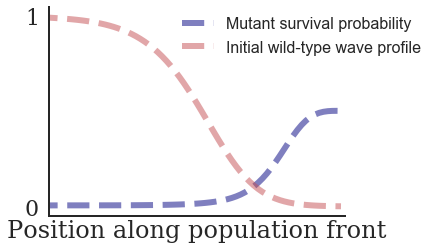

In [48]:
##box 2 figure
fig, ax1 = plt.subplots(figsize=(6,4))

#plotstyle
sns.set(font_scale=2,font='serif')
sns.set_style("white")

##generate data
K=1000
D=1

s=.1

x_init=100
dx =1
x = np.linspace(0,x_init-dx,x_init/dx)
r = .1
b0= 1 
db0 = -.005
stand = odeint(standing_wave,[b0,db0],x,args=(D,r))[:,0]
L_f = np.where(stand*K<1)[0][0]
rm=r+s
L = (2*3.141 )/( 2*((D*(rm))**.5) * (2*(rm/r -1))**.5)
u0 = rm*np.exp(-L)
dudx = rm*((D*(rm))**.5)*np.exp(-L)
p_surf = surf_prob_solve(x[:L_f],stand[0:L_f],r,rm,D,u0, dudx)
fix_count = p_surf[:,0][:L_f]*stand[:L_f]

##plot
ax1.plot(p_surf[:,0][:L_f]/rm*.5,lw=6,label = r'$\langle u(x) \rangle $',color= 'navy',linestyle='--',alpha=.5)
ax1.plot(stand[:L_f],linestyle='--',lw =6, label = r'$\langle w(x) \rangle $',alpha= .5,color = 'r')
ax1.plot((fix_count)/max(fix_count),lw=6,label = r'$\langle u(x) \rangle \langle w(x) \rangle $',color= 'k')


#legend
leg = ax1.legend(loc=3, prop={'size': 12},bbox_to_anchor=(0, .5))
leg.get_frame().set_edgecolor((1,1,1,0))
leg.get_frame().set_alpha(0)
leg.get_frame().set_linewidth(0)

#axis limits and labels
ax1.set_xlabel('$x_f$')
ax1.set_xlim(3,L_f)
ax1.set_xticks([])
ax1.set_yticks([0,1])
ax1.set_yticklabels([0,r'1'])

#spine appearance
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)

#make transpace
ax1.patch.set_facecolor('w')
ax1.patch.set_alpha(0)
#plt.tight_layout()
#plt.savefig('est_rate.pdf',facecolor=ax1.get_facecolor(), edgecolor='none' )

In [1611]:
K_space = [100,1000,10000,100000]
s_space = np.linspace(.05,.4,20)
G_fish = np.zeros((len(K_space),len(s_space)))
G_struct = np.zeros((len(K_space),len(s_space)))
for i,K in enumerate(K_space):
    for j,s in enumerate(s_space):

        D=1
        r=.1

        x_init=100
        dx =1
        x = np.linspace(0,x_init-dx,x_init/dx)
        r = .1
        b0= 1 
        db0 = -.005
        stand = odeint(standing_wave,[b0,db0],x,args=(D,r))[:,0]
        L_f = np.where(stand*K<1)[0][0]
        rm=r+s
        #print(rm)
        L = 2*3.141 /( 2*((D*(rm))**.5) * (2*(rm/r -1))**.5)
        dudx = rm*((D*(rm))**.5)*np.exp(-L)
        p_surf = surf_prob_solve(stand[0:L_f],r,rm,D, dudx)[:,0]
        G = np.sum(p_surf[0:L_f]*stand[0:L_f])
        G_fish[i,j] = G
        #print(K)
        G_struct[i,j] = np.sum(stand[0:L_f])*s*K

    

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


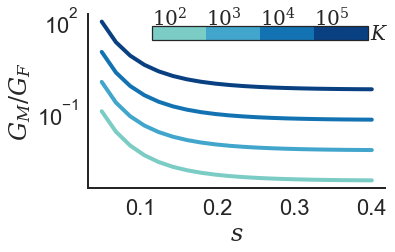

In [2511]:
##box2 figure right
from matplotlib import colors
fig, ax1 = plt.subplots(figsize=(6,4))

colors_arr = cm.GnBu(np.linspace(.5,1,4))
cmap = ListedColormap(colors_arr)
for i in range(len(K_space)):
    ax1.plot(s_space , np.array(G_struct[i])/(K*np.array(G_fish[i])),color=colors_arr[i],lw=4,label=K_space[i])

#ax1.set_yticks([0,500,1000])

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(False)
#plotstyle
sns.set(font_scale=2,font='serif')

sns.set_style("white")
#make transpace
ax1.patch.set_facecolor('w')
ax1.patch.set_alpha(0)

ax1.set_xlabel('$s$')
ax1.set_ylabel('$G_{M}/G_{F}$')
ax1.set_yscale('log')
bounds = np.linspace(0, 1, 5)

norm = colors.BoundaryNorm(boundaries=bounds, ncolors=4)
cbar_ax = 'fig.add_axes([.4, .8, .5, .05, ])'
cbar= fig.colorbar( cm.ScalarMappable(norm=norm, cmap=cmap),cax=cbar_ax,orientation = 'horizontal')

cbar_ax.set_xticklabels(['$10^%d$' % i for i in np.log10(K_space).astype(int)]) 

for tick in cbar_ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
    tick.set_fontsize(20)

cbar_ax.tick_params(axis=u'both', which=u'both',length=0,pad=-34)
cbar_ax.set_xlabel('$K$',rotation=0,fontsize=20)
cbar_ax.xaxis.set_label_coords(1.05,1.1)
plt.tight_layout()

plt.savefig('sub_rate.pdf',facecolor=ax1.get_facecolor(), edgecolor='none' )

## Results

In [148]:
list(zip(product(np.arange(.02,.2,.02),np.arange(.02,.2,.02)),cols))

[((0.02, 0.02), 0.15),
 ((0.02, 0.04), 0.36),
 ((0.02, 0.06), 0.57),
 ((0.02, 0.08), 0.78)]

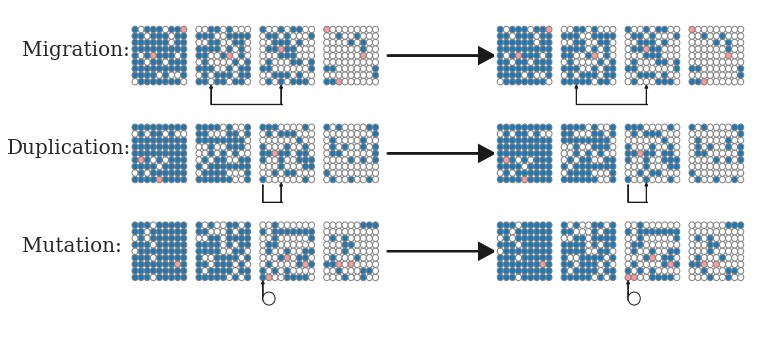

In [221]:
pal = sns.color_palette("Paired",12)
colors=[None,(1,1,1),pal[1],pal[4]]

fig,axs = plt.subplots(1,2,figsize=(12,6))
ax=axs[0]

axs[1].axis('Off')

np.random.seed=13
cols = [.15,.36,.57,.78]
rows = [.75,.45,.15]
recs = [Rectangle([col,row],.2,.2,fill=False) for col,row in product(cols,rows) ]
recs2 = [Rectangle([col,row],.2,.2,fill=False) for col,row in product(cols,rows) ]


circs=[]
circs2=[]
for col in cols:
    for row in rows: 
        for x,y in product(np.arange(.02,.2,.02),np.arange(.02,.2,.02)):
            color = np.random.choice(colors,p = [0,col,1-col-.02,.02])
        
            circs.append(Circle([col+x,row+y],.01,edgecolor='grey',facecolor = color))
            circs2.append(Circle([col+x,row+y],.01,edgecolor='grey',facecolor = color))

mig1 = (81*3 +9*2)
mig2 = (81*6 +9*3)
circs[mig1].set_facecolor(colors[1])
circs[mig2].set_facecolor(colors[2])
circs2[mig1].set_facecolor(colors[2])
circs2[mig2].set_facecolor(colors[1])

dup1 = 81*7
dup2 = 81*7 + 3*9
circs[dup1].set_facecolor(colors[2])
circs[dup2].set_facecolor(colors[1])
circs2[dup1].set_facecolor(colors[2])
circs2[dup2].set_facecolor(colors[2])


mut = 81*8
circs[mut].set_facecolor(colors[2])
circs2[mut].set_facecolor(colors[3])





ax.text(-.2,.85,'Migration:',fontsize=20)

ax.text(-.25,.55,'Duplication:',fontsize=20)

ax.text(-.2,.25,'Mutation:',fontsize=20)

for circ in circs:
    ax.add_artist(circ)
for circ in circs2:
    axs[1].add_artist(circ)
for rec in recs:
    ax.add_artist(rec)
for rec in recs2:
    axs[1].add_artist(rec)

    

ax.axis('Off')

for ax in axs:
    ax.arrow(.42,.7,0,.05,clip_on=False,head_length=.01,head_width=.01,color='k')
    ax.arrow(.42,.7,.23,0,clip_on=False,color='k')
    ax.arrow(.65,.7,0,.05,clip_on=False,head_length=.01,head_width=.01,color='k')


    ax.arrow(.59,.4,0,.05,clip_on=False,color='k')
    ax.arrow(.59,.4,.06,0,clip_on=False,color='k')
    ax.arrow(.65,.4,0,.05,clip_on=False,head_length=.01,head_width=.01,color='k')

    ax.arrow(.59,.1,0,.05,clip_on=False,head_length=.01,head_width=.01,color='k',joinstyle='round')

    arrow_circ= Circle([.61,0.105],.02,edgecolor='k',facecolor = 'w',clip_on=False)
    ax.add_artist(arrow_circ)
    
axs[0].arrow(1,.85,.3,0,clip_on=False,color='k',head_length=.05,head_width=.05,lw=2)
axs[0].arrow(1,.55,.3,0,clip_on=False,color='k',head_length=.05,head_width=.05,lw=2)
axs[0].arrow(1,.25,.3,0,clip_on=False,color='k',head_length=.05,head_width=.05,lw=2)
plt.savefig('fig1a.pdf')

### One-dimesnional stepping stone model

We simulate evolution during range expansion using a one dimensional stepping-stone model, which is a now well establish modification of that of Kimura et al. Briefly, the algorithm utilizes demes that are each filled with up to $K$ particles. Particles can represent a vacancy or an individidual, with any number of 0 to $N$ beneficial mutations. At each computational time-step the alogrithm first performs a migration step in which a random particle is exchange with a partocle from a neighboring deme, then a duplication step in which a random particle is duplicated, with the duplicate replacing another particle in the same deme, and the a mutation step, in which the a random particle is replace a particle with one additional beneficial mutation. 

The probability of migration is 1, as is every duplication even, except for replacement of an individual with a vacancy which occurs with probability $1-r*\alpha^N$, where $\alpha$ describes the magnitude of the mutations beneficial advantage. The mutation occurs with probability $U_b$ for all individuals regardless of how many mutations they have. 

This model is also equivelent in the continuous to a stochastic Fisher wave equation with genetic drift and mutation dynamics described according to a Moran process. 

We initialize the wave using a standing wave solution of a Fisher equation in the co-moving frame, and impliment the above algorithm using a moving simulation box, efficetively focusing on only the wave front. 

In [3]:
n_gen = 100
K = 500
n_allele = 2
r = .1
alpha = 5
mu = .001
 
out = run_stepping_stone(n_gen,K,r,alpha,mu,dist_key = 'normal')

In [90]:
t_samp = np.array([1200,1800,2400,3000])
x_space=np.arange(50)
df=pd.DataFrame()
columns=['t','x']
columns.append('b'+str())
for t in t_samp.astype(int):
    for x in range(len((x_space))):
        row=[int(t/100),x_space[x]]
        columns=['t','x']
        for i in range(n_allele+1):
            row.append(np.sum(out[t][x][(i+1):]))
            columns.append('b'+str(i))
        
        df=df.append(pd.DataFrame(row,index=columns).T,
                  ignore_index=True)


We simulate evolution of a mutant population with up to one mutation at a given set of sample parameter values

In [91]:
df['t']=df['t'].astype(int)

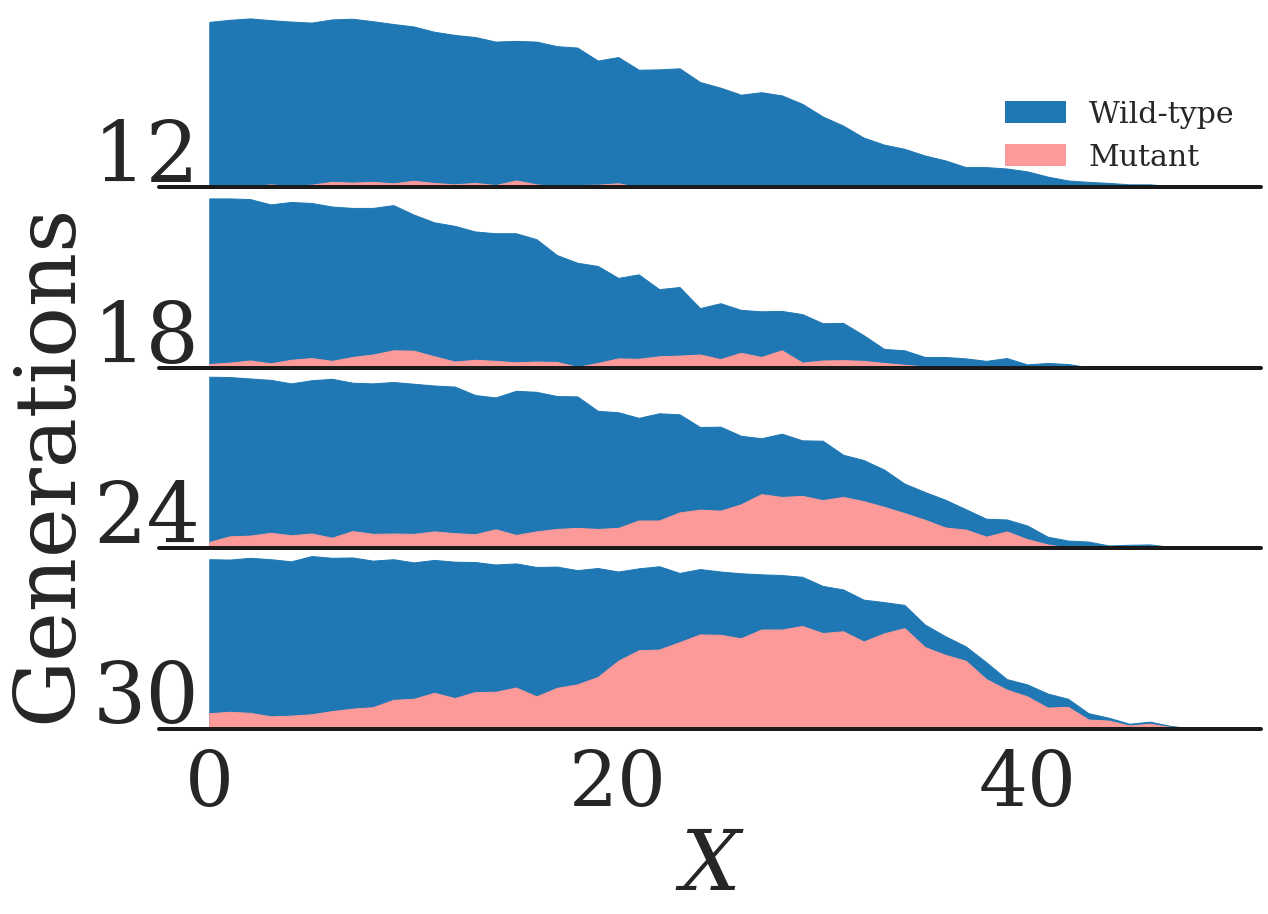

In [222]:
## Figure 1a
##code adapted from :  https://seaborn.pydata.org/examples/kde_ridgeplot.html
##restrict to space of inserest (in lieu of  plt.xlim function)
#xmax = np.where(np.sum(hist[int(t_samp[-1])][:],axis=0)*K<1)[0][0]*1.1
#df= df[df['x']<x_space[int(xmax)]][df['x']>0]


sns.set(style="white",font ='serif',rc={"axes.facecolor": (0, 0, 0, 0),},font_scale=7)

# Initialize the FacetGrid objects
pal = sns.color_palette("Paired",10)
g = sns.FacetGrid(df, row="t",hue= "t" ,aspect=5, height=4 )

#plot data 
g.map(plt.fill_between,"x","b0",clip_on=False,color = pal[1], label = 'Wild-type')
g.map(plt.fill_between,"x","b1",clip_on=False,color = pal[4], label = 'Mutant')
g.map(plt.axhline,y=0,lw=4,clip_on=False,color='k')


# Define and use a simple function to label the plot in axes coordinates
def label(x,color,label):
    ax = plt.gca()
    ax.text(-.06, .2, int(label),
            ha="left", va="center", transform=ax.transAxes)


#adjust plot 
g.map(label,'t')
g.fig.subplots_adjust(hspace=-.05)
g.set_titles("")
g.set(yticks=[])
g.set_ylabels("")
g.despine(bottom=True, left=True)
ax = g.facet_axis(-2,0)
ax.set_ylabel('Generations', labelpad = 70)
ax = g.facet_axis(-1,0)
ax.set_xlabel('$X$')

cols = [ pal[1],pal[4]]
states = ['Wild-type','Mutant']
colors={}
for col,st in zip(cols, states):
    colors.update({st: col})
handles = []
for sp in colors.keys():
    handles.append(mpl.patches.Patch(color=colors[sp], label=sp))
    
leg = ax.legend(handles=handles,bbox_to_anchor=(1, 3.5),fontsize=30)
leg.get_frame().set_facecolor('w')
leg.get_frame().set_edgecolor('w')
leg.get_frame().set_alpha(0)

ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)

#g.savefig('fig1b.pdf',facecolor=ax.get_facecolor(), edgecolor='none' )

In [2]:
n_gen = 3000
K = 500
n_allele = 10
r = .1
alpha = 5
mu = .001
 
out = run_stepping_stone(n_gen ,K ,n_allele ,r ,alpha ,mu )

(array([0]),)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [6]:
(np.array([0]),)[0][0]

0

In [303]:
t_samp = np.array([1200,1800,2400,3000])
x_space=np.arange(50)
df=pd.DataFrame()
columns=['t','x']
columns.append('b'+str())
for t in t_samp.astype(int):
    for x in range(len((x_space))):
        row=[int(t/100),x_space[x]]
        columns=['t','x']
        for i in range(n_allele+1):
            row.append(np.sum(out[t][x][(i+1):]))
            columns.append('b'+str(i))
        
        df=df.append(pd.DataFrame(row,index=columns).T,
                  ignore_index=True)


In [307]:
out[-1]

array([[ 22, 435,  41, ...,   0,   0,   0],
       [ 18, 433,  49, ...,   0,   0,   0],
       [ 12, 440,  48, ...,   0,   0,   0],
       ...,
       [500,   0,   0, ...,   0,   0,   0],
       [500,   0,   0, ...,   0,   0,   0],
       [500,   0,   0, ...,   0,   0,   0]])

In [304]:
df['t']=df['t'].astype(int)

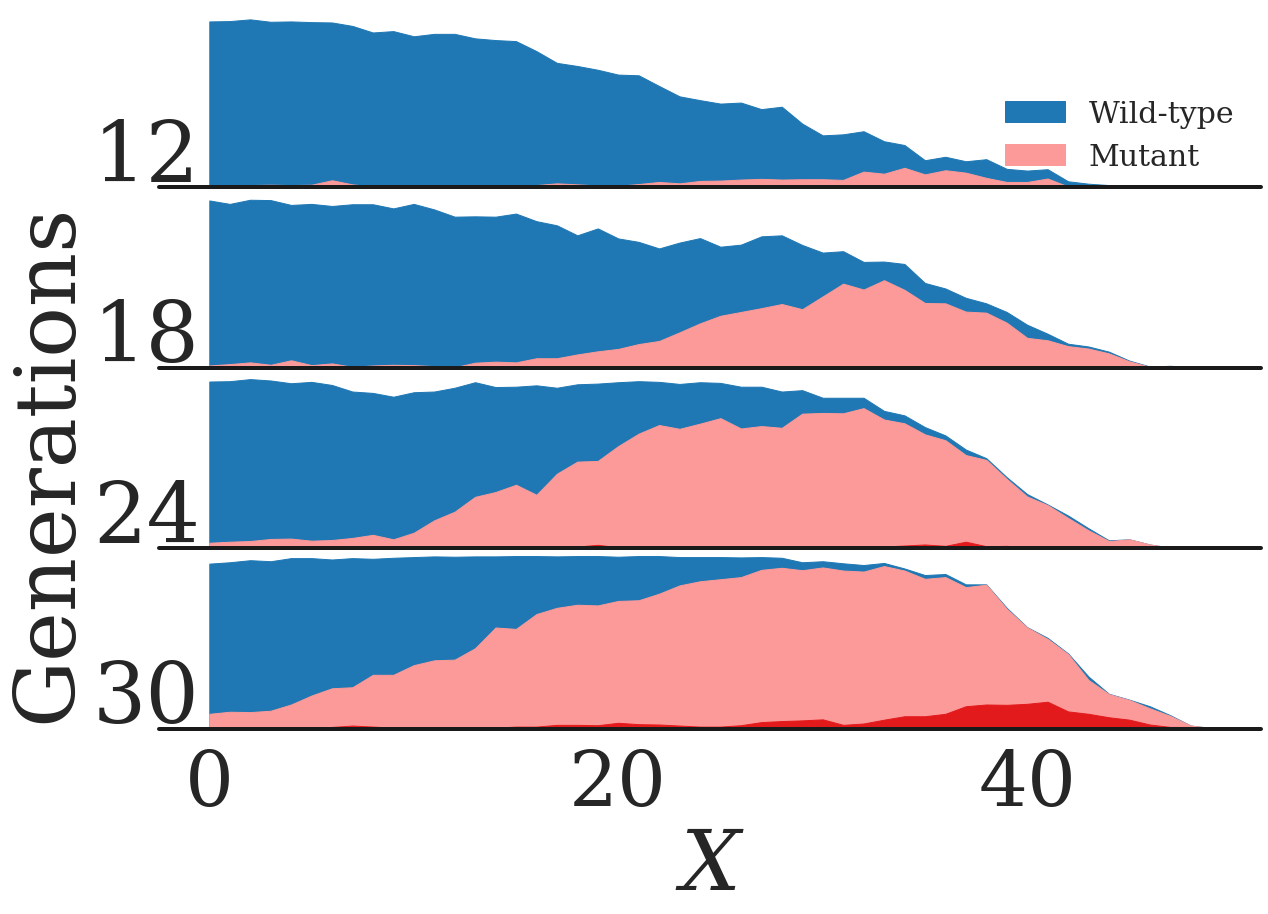

In [308]:
## Figure 1a
##code adapted from :  https://seaborn.pydata.org/examples/kde_ridgeplot.html
##restrict to space of inserest (in lieu of  plt.xlim function)
#xmax = np.where(np.sum(hist[int(t_samp[-1])][:],axis=0)*K<1)[0][0]*1.1
#df= df[df['x']<x_space[int(xmax)]][df['x']>0]


sns.set(style="white",font ='serif',rc={"axes.facecolor": (0, 0, 0, 0),},font_scale=7)

# Initialize the FacetGrid objects
pal = sns.color_palette("Paired",10)
g = sns.FacetGrid(df, row="t",hue= "t" ,aspect=5, height=4 )

#plot data 
g.map(plt.fill_between,"x","b0",clip_on=False,color = pal[1], label = 'Wild-type')
g.map(plt.fill_between,"x","b1",clip_on=False,color = pal[4], label = 'Mutant')
g.map(plt.fill_between,"x","b2",clip_on=False,color = pal[5], label = 'Mutant')
g.map(plt.fill_between,"x","b3",clip_on=False,color = pal[6], label = 'Mutant')
g.map(plt.fill_between,"x","b4",clip_on=False,color = pal[7], label = 'Mutant')
g.map(plt.axhline,y=0,lw=4,clip_on=False,color='k')


# Define and use a simple function to label the plot in axes coordinates
def label(x,color,label):
    ax = plt.gca()
    ax.text(-.06, .2, int(label),
            ha="left", va="center", transform=ax.transAxes)


#adjust plot 
g.map(label,'t')
g.fig.subplots_adjust(hspace=-.05)
g.set_titles("")
g.set(yticks=[])
g.set_ylabels("")
g.despine(bottom=True, left=True)
ax = g.facet_axis(-2,0)
ax.set_ylabel('Generations', labelpad = 70)
ax = g.facet_axis(-1,0)
ax.set_xlabel('$X$')

cols = [ pal[1],pal[4]]
statesglob = ['Wild-type','Mutant']
colors={}
for col,st in zip(cols, states):
    colors.update({st: col})
handles = []
for sp in colors.keys():
    handles.append(mpl.patches.Patch(color=colors[sp], label=sp))
    
leg = ax.legend(handles=handles,bbox_to_anchor=(1, 3.5),fontsize=30)
leg.get_frame().set_facecolor('w')
leg.get_frame().set_edgecolor('w')
leg.get_frame().set_alpha(0)

ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)

#g.savefig('fig1b.pdf',facecolor=ax.get_facecolor(), edgecolor='none' )

### Fixation and establishment times over a range of $s$, $r_w$, and $K$

We simulate evolution of a mutant population with up to one mutation over a range of parameters value. The time for mutants to appear and fix at each position on the front is recorded. Note, the code for the simulations is reproduced below for convenience however the results were generated by running a python script with identical code.

In [51]:
newest_two = max(glob.iglob('m*.npy'), key=os.path.getctime)

In [52]:
data = np.load(newest_two)

In [102]:
data=np.asarray(data[0])[:72].reshape(4,2,3,3,2)

In [143]:
data[0,1,2,1,1]

array([0.00000000e+00, 6.96050523e-04, 7.22393806e-04, 5.25171293e-03,
       5.25697284e-03, 7.11953656e-03, 7.69253920e-03, 9.10818744e-03,
       9.35833454e-03, 1.60140159e-02, 1.90133879e-02, 1.96363751e-02,
       2.20835903e-02, 2.42836564e-02, 2.44241769e-02, 2.53795427e-02,
       2.74946069e-02, 2.82051089e-02, 2.82533698e-02, 3.00883708e-02,
       3.09793291e-02, 3.15164823e-02, 3.16479785e-02, 3.17150376e-02,
       3.27959246e-02, 3.30186436e-02, 3.33029939e-02, 3.40671720e-02,
       3.48545564e-02, 3.54628742e-02, 3.65825893e-02, 3.93404704e-02,
       3.93512585e-02, 4.39092663e-02, 4.49651387e-02, 4.59165683e-02,
       4.62072346e-02, 4.69344995e-02, 4.70531360e-02, 4.71853507e-02,
       4.77588968e-02, 4.79113560e-02, 5.04580793e-02, 5.66396592e-02,
       5.76942120e-02, 5.79437635e-02, 5.83882222e-02, 5.85684940e-02,
       5.92832395e-02, 6.14546619e-02, 6.47857842e-02, 6.98612408e-02,
       7.00322571e-02, 7.12715455e-02, 7.15197102e-02, 7.20938871e-02,
      

In [94]:
data[0][6]

[array([4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]),
 array([0.00000000e+00, 9.34352214e-05, 1.11325749e-04, 8.52242604e-04,
        1.99415445e-03, 2.09879897e-03, 2.38314531e-03, 8.26603771e-03,
        8.99899543e-03, 1.06264505e-02, 1.55802591e-02, 1.64110964e-02,
        1.73290669e-02, 1.79217974e-02, 1.87238489e-02, 1.91102268e-02,
        1.95756825e-02, 1.98123625e-02, 2.29358333e-02, 2.53592861e-02,
        3.05323864e-02, 3.15455472e-02, 3.18408867e-02, 3.42440271e-02,
        3.65347183e-02, 3.68883777e-02, 3.88607245e-02, 3.88729584e-02,
        3.91587659e-02, 4.27804070e-02, 4.45947215e-02, 4.47567896e-02,
        4.52605075e-02, 4.66696969e-02, 4.72978813e-02, 5.14817131e-02,
        5.20932672e-02, 5.24495016e-02, 5.28597467e-02, 5.41687771e-02,
        5.46057251e-02, 5.74736362e-02, 5.74853359e-02, 6.16402098e-02,
        6.49676931e-02, 7.40039480e-02, 7.42862336e-02, 7.47467483e-02,
        7.65033699e-02, 7.71762999e-02, 8.2175577

In [312]:
plt.plot(data[0,0,0,0,0])
plt.plot(data[1,0,0,0,0])

plt.plot(data[3,0,0,0,0])
plt.plot(data[4,0,0,0,0])

IndexError: too many indices for array

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


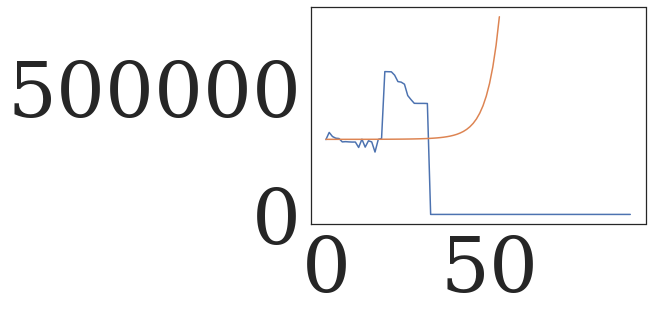

In [284]:
plt.plot(data[0,0,0,0,1])
stand = odeint(standing_wave,[1,-.1*r**.5],np.arange(len(data[0,0,0,0,1])),args=(1,r))[:,0]
stand[stand*K<1]=0
plt.plot(1 / (stand*.001)+data[0,0,0,0,1][0])

In [296]:
stand = odeint(standing_wave,[1,-.1*r**.5],np.arange(70),args=(1,r))[:,0]
w_0 = (100*stand).astype(int)
w_0 = w_0[w_0>1]

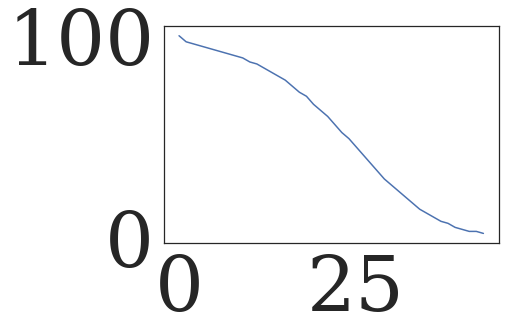

In [298]:
plt.plot(w_0)

In [293]:
len(stand[stand*K> 1])

54

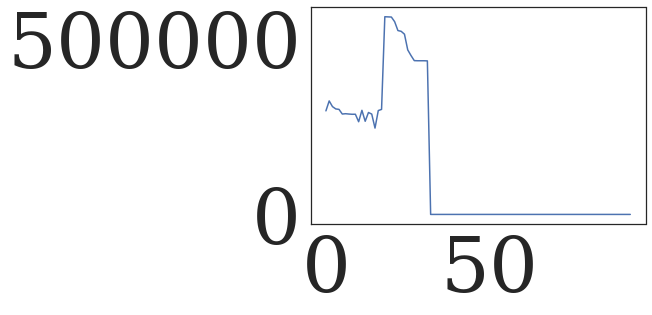

In [259]:
plt.plot(data[0,0,0,0,1])

In [6466]:

##simulating fixation of single mutant
#parameter values
mu_range =1/(10**np.array([1]))
s_range = [5]
K_range=10**np.array( [2.9])
D_range=[1]
params = [mu_range,s_range,K_range,D_range]

#record data
data_exp= []

for mu in tqdm(mu_range):
    for s in s_range:
        for K in K_range:
            for D in D_range:
                print(mu,s,K)
                ##initial standing wave solution



                r = .1
                x_init=100
                dx =.5*(r)**.5
                x = np.linspace(0,x_init-dx,x_init/dx)
                b0= 1 
                db0 = -.005
                stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
                stand[stand<0]=0
                L_f = np.where(stand*K<1)[0][0]



                R=100
                dR =.5*(r)**.5
                R_space = np.linspace(0,R-dR,R/dR)


                #initial conditions

                b0= np.append(stand,np.zeros(len(R_space)-len(x)))
                b1 = np.zeros(len(R_space))
                b = np.array([b0,b1])
                dx=dR ##spatial resolution to be numerically solvedequation through time
               
                dt= 1/K
                t=0
                ##initialize arrays to record fixation times
                fb_1 =np.zeros(L_f)==1
                eb_1 =np.zeros(L_f)==1
                fix_times=[]
                est_times=[]
                fixed = False

                ##simulation until fixaiton along entire fron
                while not fixed:
                    #solve stochastich Fisher equation for on time step
                    db = sFisher_1max(b,R_space,dt,mu,s,r,K,D)
                    ##add new alleles to b vector
                    b_1 = b+dt*db  ##compute new population density per Euler-Murayama method
                    for i in range(len(b_1)):
                        b_1[i,(b_1[i]/(K*mu))<(1*10**-7)]=0
                                ##remove any hanging empty, vectors to keep it resonable size
                    ##record population
                    b = b_1

                    ### position where total population density goes to 0, or the "front end"
                    btot = np.sum(b,axis=0)
                    f_end = max(np.where((btot*K)<1)[0][0],L_f)


                    ##check where the wild type wave is exteinct along the front
                    front_bools = np.array((b[0][f_end-L_f:f_end]*K)<1)
                    est_bools = np.array((b[1][f_end-L_f:f_end]*K)>1)
                    fix_bools=front_bools*est_bools
                    ##record the time of any new fixations
                    fix_times.append((fb_1^fix_bools)*t)
                    fb_1 = fix_bools
                    fixed = all(fix_bools)
                    
                    ##check where the wild type wave is extinct along the front
                    est_bools = (b[1][f_end-L_f:f_end]*K)>1
                    est_times.append((eb_1^est_bools)*t)
                    eb_1 = est_bools
                    if f_end > (4*L_f):
                        for i in range(len(b)):
                            b[i] = np.append(b[i][2*L_f:], np.zeros(2*L_f))

                    t+=1


                data_exp.append([np.array(fix_times)[:,:].max(axis=0)*dt,
                               np.array(est_times)[:,:].max(axis=0)*dt])
               






  0%|          | 0/1 [00:00<?, ?it/s]/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


0.1 5 794.3282347242813


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
##save simulation results
#np.save('data_exp.npy', np.array(data_exp))

In [5]:
##load simulation results
data_exp = np.load('data_exp1.npy')


In [6]:
data_exp=np.array(data_exp).reshape(5,3,3,2,2)

In [7700]:
(np.mean(data_exp[:,0,0,0,0],axis=0)

124

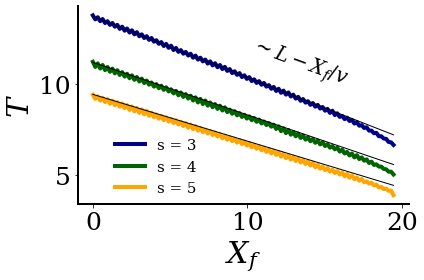

In [215]:
fig,ax = plt.subplots(figsize=(6,4))
colors = ['darkblue','darkgreen','orange',]


for i in [0,1,2]:
    ax.plot(x[0:L_f],np.mean(data_exp[:,0,i,0,0],axis=0),'b',lw=4,label ='s = %d' %s[i],color = colors[i])
    ax.plot(x[0:L_f],(.5*(x[L_f]-x[0:L_f] ))/ ( ((s[i]+1)**.5)-.5) +.5+np.mean(data_exp[:,0,i,0,0],axis=0).min() ,color='k',lw=1)


ax.text(10,10,'$\sim L-X_f / v$',fontsize=20,rotation=-20)



ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(False)
leg = ax.legend(fontsize=15,edgecolor='w',bbox_to_anchor=(.4, .4))
ax.set_ylabel('$T$',fontsize=30)
ax.set_xlabel('$X_f$',fontsize=30)
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25)
leg.get_frame().set_alpha(0)
ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)
plt.tight_layout()
plt.savefig('fig2a.pdf',facecolor=ax.get_facecolor(), edgecolor='none' )

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


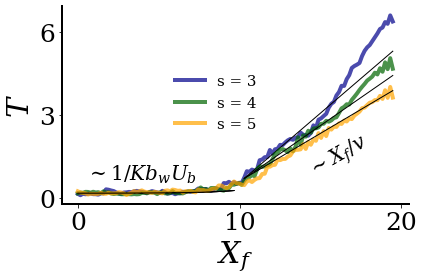

In [206]:
fig,ax = plt.subplots(figsize=(6,4))

colors = ['darkblue','darkgreen','orange',]

mu=10**(-2)
s=np.array([3,4,5])
r=.1
K=10**3.1
D=1


r = .1
x_init=100
dx =.5*(r)**.5
x = np.linspace(0,x_init-dx,x_init/dx)
b0= 1 
db0 = -.05
stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
stand[stand<0]=0
L_f = np.where((stand*K)<1)[0][0]

for i in [0,1,2]:
    ax.plot(x[:L_f],np.mean(data_exp[:,0,i,0,1],axis=0)[:L_f],'b',lw=4,label ='s = %d' %s[i],color =colors[i] ,alpha=.7)
    ax.plot(x[:62],1/(stand[:62]*mu*K)+.1,color='k',lw=1)
    ax.plot(x[65:L_f],(.5*x[0:L_f-65] )/ ( ((s[i]+1)**.5)-1) +(1/(stand[:66]*mu*K)+.5)[65] ,color='k',lw=1)


ax.text(.5,.65,'$\sim 1 / K b_w U_b$',fontsize=20)


ax.text(14,.8,'$\sim X_f / v$',fontsize=20,rotation=30)
    





ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(False)
leg = ax.legend(fontsize=15,edgecolor='w',bbox_to_anchor=(.6, .3))
ax.set_ylabel('$T$',fontsize=30)
ax.set_xlabel('$X_f$',fontsize=30)
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25)
leg.get_frame().set_alpha(0)
ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)
ax.set_yticks([0,3,6])
plt.tight_layout()
#plt.savefig('fig2b.pdf',facecolor=ax.get_facecolor(), edgecolor='none' )

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


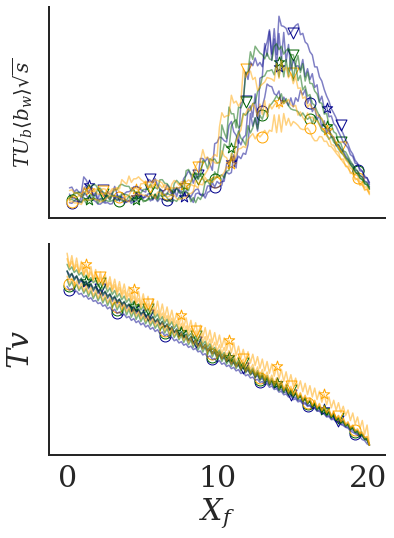

In [7772]:
###figure 1b


##parameter values
mu_range =1/(10**np.array([2,2.15,2.3]))
s_range = [3,4,5]


fig,ax=plt.subplots(2,1,sharex=True,figsize=(6,8))
colors = ['darkblue','darkgreen','orange',]
mark= ['o','*','v']
samp=20
star = [1,8,14]
r = .1
K=10**3.3
x_init=100
dx =.5*(r)**.5
x = np.linspace(0,x_init-dx,x_init/dx)
b0= 1 
db0 = -.005
stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
stand[stand<0]=0
L_f = np.where(stand*K<1)[0][0]
for i,m in enumerate(mu_range):
    for j,s in enumerate(s_range):
        L_f =len(data_exp[0,i,j,1,1])
        est=np.mean(data_exp[:,i,j,1,1],axis=0)*m*stand[:L_f]*s
        fix =(np.mean(data_exp[:,i,j,1,0],axis=0) -np.mean(data_exp[:,i,j,1,0],axis=0).min())*( ((s+1)**.5) -1) *2
        ax[0].plot(R_space[1:L_f],est[1:],label=m,color=colors[i],alpha=.5)
        ax[0].scatter(R_space[1:L_f][star[j]::samp],est[star[j]::samp],
                   marker = mark[j],color='w',edgecolor=colors[i],s=120)
        
        ax[1].plot(R_space[:L_f],fix,label=m,color=colors[i],alpha=.5)
        ax[1].scatter(R_space[:L_f][star[j]::samp],fix[star[j]::samp],
                   marker = mark[j],color='w',edgecolor=colors[i],s=120)
        


for side in ['bottom','left']:
    for a in ax:
        a.spines[side].set_linewidth(2)

    
for side in ['top','right']:
    for a in ax:
        a.spines[side].set_linewidth(False)
ax[0].set_yticklabels('')
ax[1].set_yticklabels('')
ax[0].set_ylabel(r'$T U_b \langle b_w \rangle \sqrt{s}$',fontsize=20)
ax[1].set_ylabel(r'$T v$',fontsize=30)
ax[1].set_xlabel('$X_f$',fontsize=30)
ax[0].tick_params(labelsize=30)
ax[1].tick_params(labelsize=30)

    
markerstyle ={}
for m,s  in zip(mark, s_range):
    markerstyle.update({s: m})
    
    
linestyle ={}    
for c,mu in zip(colors, mu_range):
    linestyle.update({mu: c})

    
    
ax[0].patch.set_facecolor('w')
ax[0].patch.set_alpha(0)
plt.tight_layout()

plt.savefig('fig1c.pdf',facecolor=ax[0].get_facecolor(), edgecolor='none' )

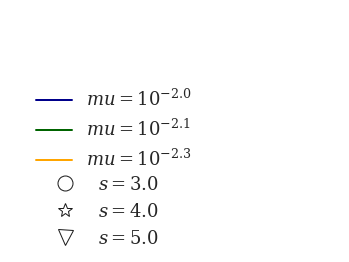

In [7725]:
fig,ax=plt.subplots()
handlesline = []   
for mu in linestyle.keys():
    handlesline.append(Line2D([0], [0], 
                           lw=2, label='$mu = 10^{%.1f}$' % np.log10(mu),color=linestyle[mu]))
handlesmark = []  
for s in markerstyle.keys():
    handlesmark.append(Line2D([0], [0], color='steelblue', 
                           lw=0, label='$s = %.1f$' % s,marker=markerstyle[s],c='w',markeredgecolor='k',markersize=15))

leg1 = ax.legend(handles=handlesline,bbox_to_anchor=(.6, .7),fontsize=18,edgecolor='w')
leg2 = ax.legend(handles=handlesmark,bbox_to_anchor=(.5, .3),fontsize=18,edgecolor='w')
legends = [leg1,leg2]
for leg in legends:
    leg.get_frame().set_alpha(0)
ax.axis('off')
ax.add_artist(leg1)

    
ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)

plt.savefig('fig1c_legend.pdf',facecolor=ax.get_facecolor(), edgecolor='none' )

Next, we estimate the average time for mutants to appear and fix from fundamental properties of Fisher waves, and population genetic arguments

In [78]:
##estimating fixation and establishment time from 'first principles'
##parameter values
mu_range =1/(10**np.array([2,2.1, 2.3]))
s_range = [1,3,4,5]
K_range=10**np.array( [3.1,3.3])
D_range=[1]
params = [mu_range,s_range,K_range,D_range]

##initialize list to store data
data_calc= []
for mu in mu_range:
    for s in s_range:
        for K in K_range:
            for D in D_range:
                r = .1
       
                
                x_init=100
                dx =.5*(r)**.5
                x = np.linspace(0,x_init-dx,x_init/dx)
                b0= 1 
                db0 = -.05
                stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
                stand[stand<0]=0
                L_f = np.where(stand*K<1)[0][0]
       
                dt=.0005
                rm = (s+1)*r
                L = (3.141*2) /(  (2*r**.5)*((2*s )**.5))
                G = stand[:L_f]*mu*K
                move_times = []
                for i in range(1,L_f):
                    move=[]
                    for j in range(i):
                        move.append((G[j]) + ((((i-j)))/ (( 2*((D*(s+1))**.5)))))
                    move_times.append(min(move))
                a = (( K*(1- np.array([min(1, i+ mu/K) for i in .98*stand[:L_f]]) ) )/(stand[:L_f]*K*mu)) -1
                t_est_mut = ( 1/ (stand[:L_f]*K*mu*(s+1)*r))

                
                t_ests=[]
                for i in range(L_f):
                    t_ests.append(np.append(t_est_mut[:i],t_est_mut[i]+(x[0:L_f-i] /(((s+1)**.5 -1)*2))))
                
                t_ests=np.asarray(t_ests)
                minim = np.where(np.sum(t_ests,axis=1)==np.sum(t_ests,axis=1).min())[0][0]

                t_est_move = np.arange(L_f) /(((s+1)**.5 -1)*4)
                R =t_ests[minim][-1]

                #fix_count = p_surf[:,0][:L_f]*stand[:L_f]*K*mu

                t_switch = np.log((K**2-1)/(.1*(1+s)) )/ (s)

                ft =  ((x[int(L_f)]-x[:int(L_f)])/(  2*((s+1)**.5  )))
                data_calc.append([ft,t_ests[minim]])

    
    

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [79]:
data_calc=np.array(data_calc).reshape(3,4,2,2)


Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x1b830cc2f0>
Traceback (most recent call last):
  File "/Users/nikhilkrishnan/anaconda3/lib/python3.7/weakref.py", line 51, in _cb
    def _cb(arg):
KeyboardInterrupt
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


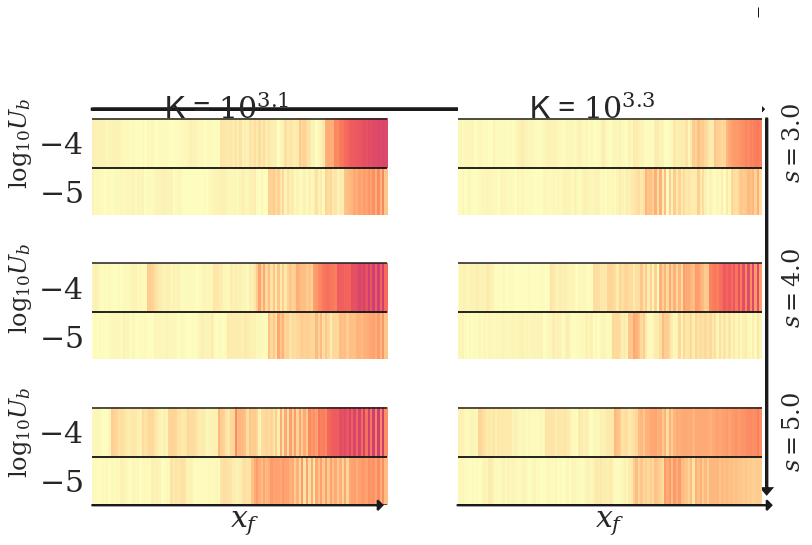

In [7249]:
##suppliment 1a

fig,ax = plt.subplots(3,2,sharex=True,sharey=True,figsize=(12,8))
#cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.set(font_scale=2,font='serif')
sns.set_style("white")

for k,s in zip([0,0,0,1,1,1],[0,1,2,0,1,2]):
    dat= []
    for i,mu in enumerate(mu_range):
        exp = data_exp[i,s,k,1]
        calc = data_calc[i,s,k,1]
        dat.append(abs(exp-calc)/max(exp))
    im = sns.heatmap(dat,ax=ax[s,k],cmap='magma_r',vmin=0,vmax=10,cbar=False,
                     cbar_ax =None) 
    ax[s,k].hlines([-1, 0],*ax[s,k].get_xlim())
    ax[s,k].hlines([0, 1],*ax[s,k].get_xlim())
    ax[s,k].hlines([2, 3],*ax[s,k].get_xlim())
    ax[s,k].hlines([1,2],*ax[s,k].get_xlim())
    #ax[s,k
    #ax[s,k].set_title([s_range[s],K_range[k]])
    
    
for i in [0,1]:
    ax[-1,i].set_xticks([])
    ax[-1,i].set_xlabel('$x_f$',fontsize=30)
    ax[0,i].text(30,3.3,['K = $10^{%.1d}$' %   np.log10(K_range[i])][0],fontsize=30)
    ax[-1,i].arrow(0,0,[90,98,109][i],0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=2)
for i in [0,1,2]:

    ax[i,0].set_ylim([0,3])
    #ax[i,0].set_yticks([0,1.5,3])
    ax[i,0].set_yticklabels(['${%.1d}$'% i for i in [-5,-4,-3]],rotation=0,fontsize=30)
    #ax[0,i].set_title(['K = $10^{%.1d}$' %   np.log10(K_range[i])][0],fontsize=30)

    ax[i,0].set_ylabel('$\log_{10}U_b$')
    ax[i,-1].yaxis.set_label_position("right")
    ax[i,-1].yaxis.tick_right()
    ax[i,-1].set_ylabel('$s = %.1f$' % s_range[i] ,rotation=90,labelpad=20)
    ax[i,-1].tick_params(axis=u'both', which=u'both',length=0)

ax[0,0].arrow([50,170,280][i],3.1,0,.2,head_width=0,head_length=0,lw=1,color='k',clip_on=False)
ax[0,1].arrow(112,[1.4,-1.7,-4.7][i],6,0,head_width=0,head_length=0,lw=1,color='k',clip_on=False)

ax[0,0].arrow(0,3.2,328,0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=3)
ax[0,1].arrow(115,3,0,-9.2,head_width=3.5,head_length=.1,clip_on=False,color = 'k',lw=3)


fig.tight_layout(rect=[0, 0, .9, 1])
#fig.subplots_adjust(wspace=-.02)
#fig.subplots_adjust(hspace=.05)
cbar_ax.set_ylabel('$|y_{exp}-y_{calc}|$')
#fig.colorbar(im,orientation='vertical',ax=ax[s,k])
plt.savefig('fig1b.pdf')

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


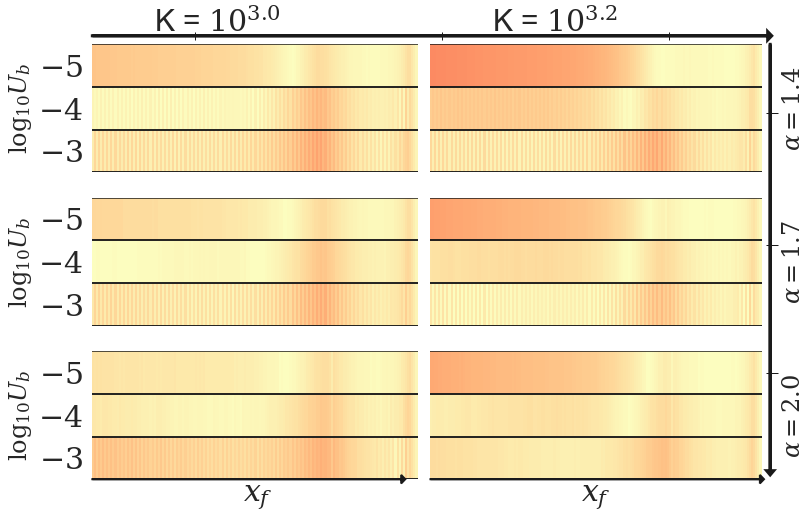

In [5380]:
##suppliment 2

fig,ax = plt.subplots(3,2,sharex=True,sharey=True,figsize=(12,8))
#cbar_ax = fig.add_axes([.91, .3, .03, .4])
sns.set(font_scale=2,font='serif')
sns.set_style("white")

for k,s in zip([0,0,0,1,1,1],[0,1,2,0,1,2]):
    dat= []
    #print(k,s)
    for i,mu in enumerate(mu_range):
        exp = (data_exp[i,s,k,0]-data_exp[i,s,k,1])
        calc = data_calc[i,s,k,0]
        dat.append(abs(exp-calc)/max(exp))

    im = sns.heatmap(dat,ax=ax[s,k],cmap='magma_r',vmin=0,vmax=1,cbar=False,
                     cbar_ax =None) 
    ax[s,k].hlines([-1, 0],*ax[s,k].get_xlim())
    ax[s,k].hlines([0, 1],*ax[s,k].get_xlim())
    ax[s,k].hlines([2, 3],*ax[s,k].get_xlim())
    ax[s,k].hlines([1,2],*ax[s,k].get_xlim())
    #ax[s,k
    #ax[s,k].set_title([s_range[s],K_range[k]])
    
    
for i in [0,1]:
    ax[-1,i].set_xticks([])
    ax[-1,i].set_xlabel('$x_f$',fontsize=30)
    ax[0,i].text(30,3.3,['K = $10^{%.1f}$' %   np.log10(K_range[i])][0],fontsize=30)
    ax[-1,i].arrow(0,0,[150,160][i],0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=2)

for i in [0,1,2]:

    ax[i,0].set_ylim([0,3])
    #ax[i,0].set_yticks([0,1.5,3])
    ax[i,0].set_yticklabels(['${%.1d}$'% i for i in [-3,-4,-5]],rotation=0,fontsize=30)
    #ax[0,i].set_title(['K = $10^{%.1d}$' %   np.log10(K_range[i])][0],fontsize=30)

    ax[i,0].set_ylabel('$\log_{10}U_b$')
    ax[i,-1].yaxis.set_label_position("right")
    ax[i,-1].yaxis.tick_right()
    ax[i,-1].set_ylabel(r'$\alpha = %.1f$' % (s_range[i]+1) ,rotation=90,labelpad=20)
    ax[i,-1].tick_params(axis=u'both', which=u'both',length=0)

    ax[0,0].arrow([50,170,280][i],3.1,0,.2,head_width=0,head_length=0,lw=1,color='k',clip_on=False)
    ax[0,1].arrow(163,[1.4,-1.7,-4.7][i],6,0,head_width=0,head_length=0,lw=1,color='k',clip_on=False)

ax[0,0].arrow(0,3.2,328,0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=3)
ax[0,1].arrow(165,3,0,-10,head_width=3.5,head_length=.1,clip_on=False,color = 'k',lw=3)


fig.tight_layout(rect=[0, 0, .9, 1])
fig.subplots_adjust(wspace=.02)
#fig.subplots_adjust(hspace=.05)

#fig.colorbar(im,orientation='vertical',ax=ax[s,k])
plt.savefig('figs2_fix.pdf')

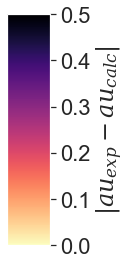

In [3617]:
##colorbar
fig = plt.figure()
ax = fig.add_axes([0, 0, .1, .8, ])
sns.set(font='serif',font_scale=2)
norm = mpl.colors.Normalize(vmin=0,vmax=.5)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='magma_r'),cax=ax)
ax.set_ylabel('$| \tau_{exp}-\tau_{calc} |$')
plt.savefig('fig1_cbar.pdf')

## Simulating clonal interference

 We expand our above model to allow for many mutations, each with a slective advantage s. Precisely:

In [7833]:
b

array([1.        , 0.99319   , 0.98808202, ..., 0.        , 0.        ,
       0.        ])

In [49]:
def sFisher(b,R_space,mu,s,r,K,D):
    a = 1+s
    dbdt=[]
    ## chane in mutation from previous allele to current allel, beings at 0
    dbmu_ = np.zeros(len(b[0]))
    btot = np.sum(b,axis=0) 
    ## iterate through each allele "i"
    for i in range(len(b)-1):
        bi = np.array(b[i])
        #total population density w.r.t. x 
        dbidt = []
        ##Stochastic fisher equation
        #dbidt = D*grad(grad(bi,dx),dx) + ((a)**i) * bi*(1-btot) +(((2*r*bi*[max(0,j) for j in (1-btot)])/K)**.5) * np.random.normal(0,1,len(bi))
        dbidt.append(D*grad(grad(bi,np.diff(R_space)[0]),np.diff(R_space)[0]))
        dbidt.append(((a)**i) * bi*(1-btot))
        dbidt.append((((2*r*(a**i)*bi*[max(0,j) for j in (1-btot)])/K*(r)**.5)**.5) * np.random.normal(0,1,len(bi))) 
        dbmu = - np.random.poisson(bi*mu)
        dbidt.append(dbmu) #beneficial mutation rate, "out" of current allele
        dbidt.append(dbmu_)
        dbdt.append(np.sum(dbidt,axis=0).tolist())
        #dbdt.append(dbidt+dbmu+dbmu_)##change in  allale population due to diffusion, growth, genetic, drift, and mutation
        dbmu_ = -dbmu #"int to next allele" of current allele
    bi = np.array(b[i])
    #total population density w.r.t. x 
    dbidt = []
    ##Stochastic fisher equation
    #dbidt = D*grad(grad(bi,dx),dx) + ((a)**i) * bi*(1-btot) +(((2*r*bi*[max(0,j) for j in (1-btot)])/K)**.5) * np.random.normal(0,1,len(bi))
    dbidt.append(D*grad(grad(bi,np.diff(R_space)[0]),np.diff(R_space)[0]))
    dbidt.append(((a)**i) * bi*(1-btot))
    dbidt.append((((2*r*(a**i)*bi*[max(0,j) for j in (1-btot)])/K*(r)**.5)**.5) * np.random.normal(0,1,len(bi))) 
    dbidt.append(dbmu_)
    dbdt.append(np.sum(dbidt,axis=0).tolist())
    return np.array(dbdt)

def sFisher_solve(t,R_space,b,func_args):
    dx=dR ##spatial resolution to be numerically solved
    K=func_args[-2] ##compact support, 1/K - if K*mu<1 this will prevent any mutant growth
    dt = t[1]-t[0] ## time step inferred from time vector
    hist = [] ##to record population density vectors at each time step
    hist.append(b)
    ## solve fisher equation through time
    for t_step in t:
        #solve stochastich Fisher equation for on time step
        db = sFisher(b,R_space,*func_args)
        ##add new alleles to b vector

       # print(len(np.array(b)[0]))
        b_1 = np.array(b)+dt*db  ##compute new population density per Euler-Murayama method
        for i in range(len(b_1)):
            b_1[i,(b_1[i])<(1/(K*10))]=0
        ##remove any hanging empty, vectors to keep it resonable size
        ##record population
        hist.append(b_1)
        b = b_1
        
    return hist

In [46]:
mu=10**-2.3
s=3
r=.1
K=10**3.2
D=1

r = .1
x_init=100
dx =.5*(r)**.5
x = np.linspace(0,x_init-dx,x_init/dx)
b0= 1 
db0 = -.05
stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
stand[stand<0]=0

tmax=20
t_step = 1/K
t=np.linspace(0,tmax,int(tmax/t_step)+1)

R=300
dR =.5*(r)**.5
R_space = np.linspace(0,R-dR,R/dR)
n=10

b= [np.append(stand,np.zeros(len(R_space)-len(x))).tolist()]
for i in range(n-1):
    b.append(np.zeros(len(R_space)).tolist())
b=np.asarray(b)

hist = sFisher_solve(t,R_space,b,func_args =[mu,s,r,K,D])
hist=np.array(hist)

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


KeyboardInterrupt: 

In [ ]:
plt.plot(hist[-1][0])
plt.plot(hist[-1][1])

In [ ]:
t=np.linspace(0,tmax,int(tmax/t_step)+1)

In [ ]:
t_samp = np.array([1,2,3,4])/t_step
x_space=np.linspace(0,R-dR,R/dR)
df=pd.DataFrame()
columns=['t','x']
columns.append('b'+str())
for t in t_samp.astype(int):
    for x in range(len(x_space)):
        row=[int(t*t_step),x_space[x]]
        
        columns=['t','x']
        for i in range(len(hist[t])):
            
            row.append(np.sum(np.array(hist[t])[i:,x]))
            columns.append('b'+str(i))
        
        df=df.append(pd.DataFrame(row,index=columns).T,
                  ignore_index=True)


In [ ]:
df['t']=df['t'].astype(int)

In [ ]:
## Figure 1a
##code adapted from :  https://seaborn.pydata.org/examples/kde_ridgeplot.html
##restrict to space of inserest (in lieu of  plt.xlim function)
xmax = np.where(np.sum(hist[int(t_samp[-1])][:],axis=0)*K<1)[0][0]*1.1
df= df[df['x']<xmax][df['x']>0]

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0),},font_scale=7)

# Initialize the FacetGrid objects
pal = sns.color_palette("Paired",12)
colors=[pal[1],pal[4],pal[5],pal[9],pal[7],pal[11],pal[10],pal[0]]
g = sns.FacetGrid(df, row="t",hue= "t" ,aspect=5, height=4 )

#plot data 
for i in range(len(df.columns)-2):
    g.map(plt.fill_between,"x","b"+str(i),clip_on=False,color = colors[i])

g.map(plt.axhline,y=0,lw=2,clip_on=False,color='k')


# Define and use a simple function to label the plot in axes coordinates
def label(x,color,label):
    ax = plt.gca()
    ax.text(-.07, .2, int(label),
            ha="left", va="center", transform=ax.transAxes)


#adjust plot 
g.map(label,'t')
g.fig.subplots_adjust(hspace=-.05)
g.set_titles("")
g.set(yticks=[])
g.set_ylabels("")
g.despine(bottom=True, left=True)
ax = g.facet_axis(-3,0)
ax.set_ylabel('Generations', labelpad=70)
ax = g.facet_axis(-1,0)
ax.set_xlabel('$X$')
#g.savefig('diff_rep.pdf')

We will simulate the evolution of Fisher waves a large number of possible beneficial mutations over a range of values. We will record where along the front the population is polygenic.

In [1283]:
from evo_diffeqs import*
from tqdm import tqdm
##simulating evolution of multiple competing mutant waves
##parameter values
mu_range =1/(10**np.array([5]))
s_range = [.1]
K_range=10**np.array( [7])
D_range=[1]
params = [mu_range,s_range,K_range,D_range]

#record data
CII_exp= []

for mu in mu_range:
    for s in s_range:
        for K in K_range:
            for D in D_range:
                print(mu,s,K)
                ##initial standing wave solution
                r = .1
                x_init=100
                dx =1*(r)**.5
                x = np.linspace(0,x_init-dx,x_init/dx)
                b0= 1 
                db0 = -.005
                stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
                stand[stand<0]=0
                L_f = np.where(stand*K<1)[0][0]

                #initial conditions

                R=1000
                dR =1*(r)**.5
                RdR= int(R/dR)
                b= np.append(stand,np.zeros(RdR-int(x_init/dx)))

                b = [b]
                dx=dR ##spatial resolution to be numerically solvedequation through time
                dt =.0005
                t=0

                ##simulation until fixaiton along entire fron
                ##initialize arrays to record fixation times
                fb_1 =np.zeros(L_f)==1
                eb_1 =np.zeros(L_f)==1
                fix_times=[]
                est_times=[]
                fixed = False
                
                ##simulation until fixaiton along entire fron
                while not fixed:
                    #solve stochastich Fisher equation for on time step
                    db = sFisher(b,dx,mu,s,r,K,D)
                    ##add new alleles to b vector
                    for i in range(len(db)-len(b)):
            
                         b.append(np.zeros(RdR))
       # print(len(np.array(b)[0]))
                    b_1 = np.array(b)+dt*db  ##compute new population density per Euler-Murayama method
                    for i in range(len(b_1)):
                        b_1[i,b_1[i]<(10**-10)] =0 
        ##remove any hanging empty, vectors to keep it resonable size
                    while  np.all(b_1[-1]==0):
                        b_1 = b_1[:-1]
                                ##remove any hanging empty, vectors to keep it resonable size
                    ##record population
                    b = b_1

                    ### position where total population density goes to 0, or the "front end"
                    btot = np.sum(b,axis=0)
                    f_end = max(np.where(btot*K<1)[0][0],L_f)


                    ##check where the wild type wave is exteinct along the front
                    front_bools = np.array((b[0][f_end-L_f:f_end]*K)<1)


                    ##record the time of any new fixations
                    fix_times.append((fb_1^front_bools)*t)
                    fb_1 = front_bools
                    fixed = all(front_bools)
                    
                    ##check where the wild type wave is extinct along the front
                    t+=1
                    b =b.tolist()

                ##record polygenecity of final population density through time

                btot = np.sum(b,axis=0)
                f_end = max(np.where(btot*K<1)[0][0],L_f)
                b=np.array(b)
                poly_bools = np.sum(b[:,f_end-L_f:f_end]*K>1,axis=0)
                
                CII_exp.append(poly_bools)
                ##simulation until fixaiton along entire fron

1e-05 0.1 10000000


/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [1192]:
#np.save('CII_exp.npy', np.array(CII_exp))

In [6187]:
##load simulation results
CII_exp = np.load('CII_exp.npy')

In [6188]:
CII_exp = np.array(CII_exp).reshape(4,3,2)

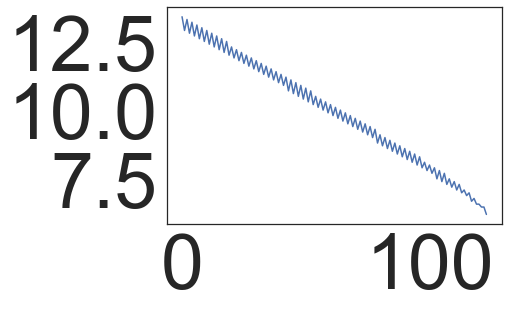

In [7276]:
plt.plot(data_exp[0,0,0,0])

In [86]:
data_calc[2,3,1,0]

array([4.13416462, 4.10186646, 4.0695683 , 4.03727014, 4.00497198,
       3.97267382, 3.94037566, 3.90807749, 3.87577933, 3.84348117,
       3.81118301, 3.77888485, 3.74658669, 3.71428853, 3.68199037,
       3.64969221, 3.61739404, 3.58509588, 3.55279772, 3.52049956,
       3.4882014 , 3.45590324, 3.42360508, 3.39130692, 3.35900876,
       3.32671059, 3.29441243, 3.26211427, 3.22981611, 3.19751795,
       3.16521979, 3.13292163, 3.10062347, 3.06832531, 3.03602714,
       3.00372898, 2.97143082, 2.93913266, 2.9068345 , 2.87453634,
       2.84223818, 2.80994002, 2.77764186, 2.74534369, 2.71304553,
       2.68074737, 2.64844921, 2.61615105, 2.58385289, 2.55155473,
       2.51925657, 2.48695841, 2.45466024, 2.42236208, 2.39006392,
       2.35776576, 2.3254676 , 2.29316944, 2.26087128, 2.22857312,
       2.19627496, 2.16397679, 2.13167863, 2.09938047, 2.06708231,
       2.03478415, 2.00248599, 1.97018783, 1.93788967, 1.90559151,
       1.87329334, 1.84099518, 1.80869702, 1.77639886, 1.74410

In [90]:
##estimating fixation and establishment time from 'first principles'
##parameter values
mu_range =1/(10**np.array([2,2.1,2.3]))
s_range = [1,3,4,5]
K_range=10**np.array([3.1,3.3])
D_range=[1]
params = [mu_range,s_range,K_range,D_range]
##initialize list to store data
CII_calc= []
for i,mu in enumerate(mu_range):
    for j,s in enumerate(s_range):
        for k,K in enumerate(K_range):
            CII_calc.append(np.log(data_calc[i,j,k,0]  /data_calc[i,j,k,1]))
                
            
                
    
    

In [91]:
CII_calc = np.array(CII_calc).reshape(3,4,2)

IndexError: index 2 is out of bounds for axis 0 with size 2

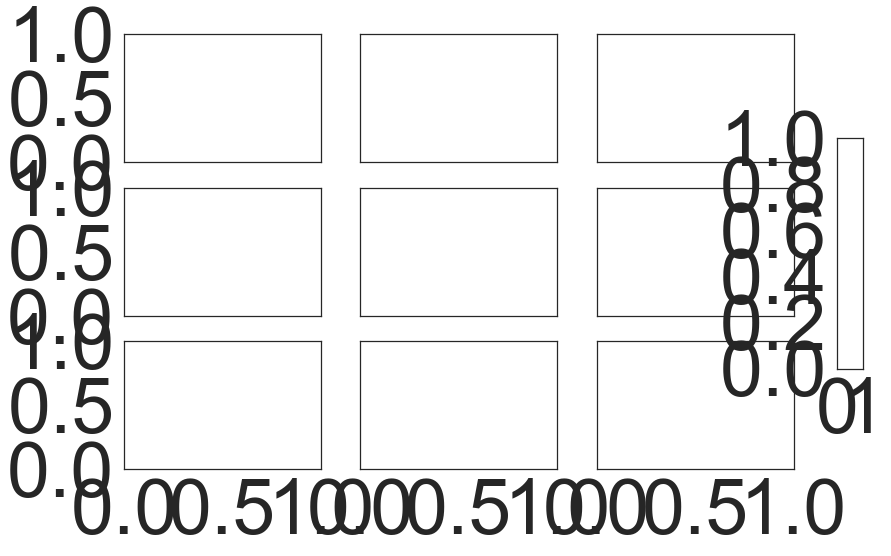

In [7583]:
fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(12,8))
cbar_ax = fig.add_axes([.95, .3, .03, .4])
sns.set(font_scale=2,font='serif')
sns.set_style("white")
mu_range =1/(10**np.array([5,4,3]))
s_range = [.5,1,2]
for k,s in zip([0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]):
    dat= []
    #print(k,s)
    for i,mu in enumerate(mu_range):
        dat.append(CII_calc[i,s,k])
    im = sns.heatmap(dat,ax=ax[s,k],cmap='RdBu_r',center=0,cbar=(k==2 and s==2),
                     cbar_ax =None if (k!=2 and s!=2) else cbar_ax) 
    ax[s,k].hlines([-1, 0],*ax[s,k].get_xlim())
    ax[s,k].hlines([0, 1],*ax[s,k].get_xlim())
    ax[s,k].hlines([2, 3],*ax[s,k].get_xlim())
    ax[s,k].hlines([1,2],*ax[s,k].get_xlim())
    #ax[s,k
    #ax[s,k].set_title([s_range[s],K_range[k]])
    
    
    
    
for i in [0,1,2]:
    ax[-1,i].set_xticks([])
    ax[-1,i].set_xlabel('$x_f$',fontsize=30)
    ax[i,0].set_ylim([0,3])
    #ax[i,0].set_yticks([0,1.5,3])
    ax[i,0].set_yticklabels(['${%.1d}$'% i for i in [-5,-4,-3]],rotation=0,fontsize=30)
    #ax[0,i].set_title(['K = $10^{%.1d}$' %   np.log10(K_range[i])][0],fontsize=30)
    ax[0,i].text(30,3.3,['K = $10^{%.1d}$' %   np.log10(K_range[i])][0],fontsize=30)
    ax[i,0].set_ylabel('$\log_{10}U_b$')
    ax[i,-1].yaxis.set_label_position("right")
    ax[i,-1].yaxis.tick_right()
    ax[i,-1].set_ylabel('$s = %.1f$' % s_range[i] ,rotation=90,labelpad=20)
    ax[i,-1].tick_params(axis=u'both', which=u'both',length=0)
    ax[-1,i].arrow(0,0,[90,98,109][i],0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=2)
    ax[0,0].arrow([50,170,280][i],3.1,0,.2,head_width=0,head_length=0,lw=1,color='k',clip_on=False)
    ax[0,2].arrow(112,[1.4,-1.7,-4.7][i],6,0,head_width=0,head_length=0,lw=1,color='k',clip_on=False)

ax[0,0].arrow(0,3.2,328,0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=3)
ax[0,2].arrow(115,3,0,-9.2,head_width=3.5,head_length=.1,clip_on=False,color = 'k',lw=3)

cbar_ax.set_yticks([-2.3,2.3])
#cbar_ax.set_yticklabels(['SSWM',2.3])
fig.tight_layout(rect=[0, 0, .9, 1])
fig.subplots_adjust(wspace=-.02)
fig.subplots_adjust(hspace=.05)
cbar_ax.set_ylabel('$|y_{exp}-y_{calc}|$')

#fig.colorbar(im,orientation='vertical',ax=ax[s,k])
plt.savefig('fig2b.pdf')

AttributeError: module 'matplotlib.colors' has no attribute 'Diverging'

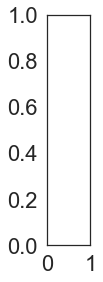

In [4838]:
##colorbar
fig = plt.figure()
ax = fig.add_axes([0, 0, .1, .8, ])
sns.set(font='serif',font_scale=2)
norm = mpl.colors.Diverging(vmin=-3,center=0,vmax=10)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='BuRd_r'),cax=ax)
ax.set_ylabel('$| \tau_{exp}-\tau_{calc} |$')
plt.savefig('fig1_cbar.pdf')

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(1557.625, 0.5, '$|y_{exp}-y_{calc}|$')

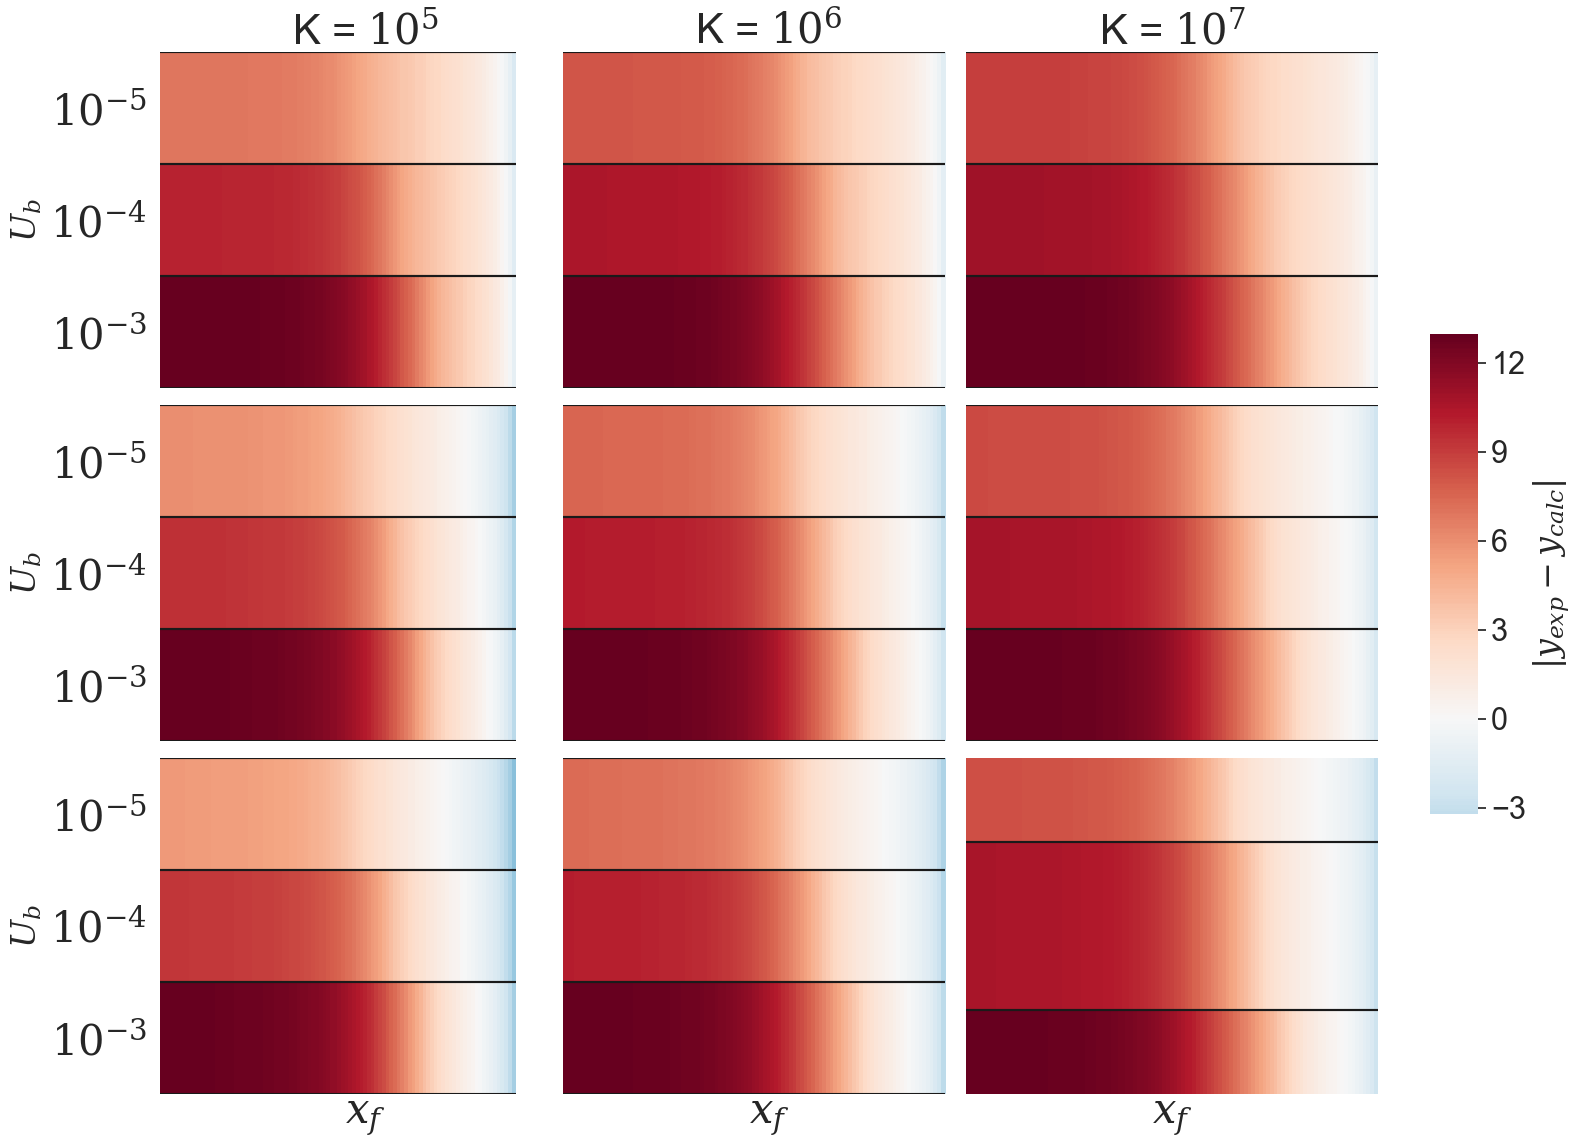

In [2276]:
fig,ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(16,12))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
#sns.set(font_scale=3)
sns.set_style("white")

for k,s in zip([0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]):
    dat= []
    print(k,s)
    for i,mu in enumerate(mu_range):

        dat.append(CII_calc[i,s,k])
    im = sns.heatmap(dat,ax=ax[s,k],cmap='RdBu_r',center=0,cbar=(k==2 and s==2),
                     cbar_ax =None if (k!=2 and s!=2) else cbar_ax) 
    ax[s,k].hlines([-1, 0],*ax[s,k].get_xlim())
    ax[s,k].hlines([0, 1],*ax[s,k].get_xlim())
    ax[s,k].hlines([2, 3],*ax[s,k].get_xlim())
    ax[s,k].hlines([1,2],*ax[s,k].get_xlim())
    #ax[s,k
    #ax[s,k].set_title([s_range[s],K_range[k]])
    
    
    
    
for i in [0,1,2]:
    ax[-1,i].set_xticks([])
    ax[-1,i].set_xlabel('$x_f$',fontsize=30)
    
    #ax[i,0].set_yticks([0,1.5,3])
    ax[i,0].set_yticklabels(['$10^{%.1d}$'% i for i in [-5,-4,-3]],rotation=0,fontsize=30)
    ax[0,i].set_title(['K = $10^{%.1d}$' %   np.log10(K_range[i])][0],fontsize=30)
    ax[i,0].set_ylabel('$U_b$')
   

fig.tight_layout(rect=[0, 0, .9, 1])
fig.subplots_adjust(wspace=-.02)
fig.subplots_adjust(hspace=.05)
cbar_ax.set_ylabel('$|y_{exp}-y_{calc}|$')
#fig.colorbar(im,orientation='vertical',ax=ax[s,k])

0 0
0 1
0 2
1 0
1 1
1 2


/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Text(1108.63, 0.5, '$|y_{exp}-y_{calc}|$')

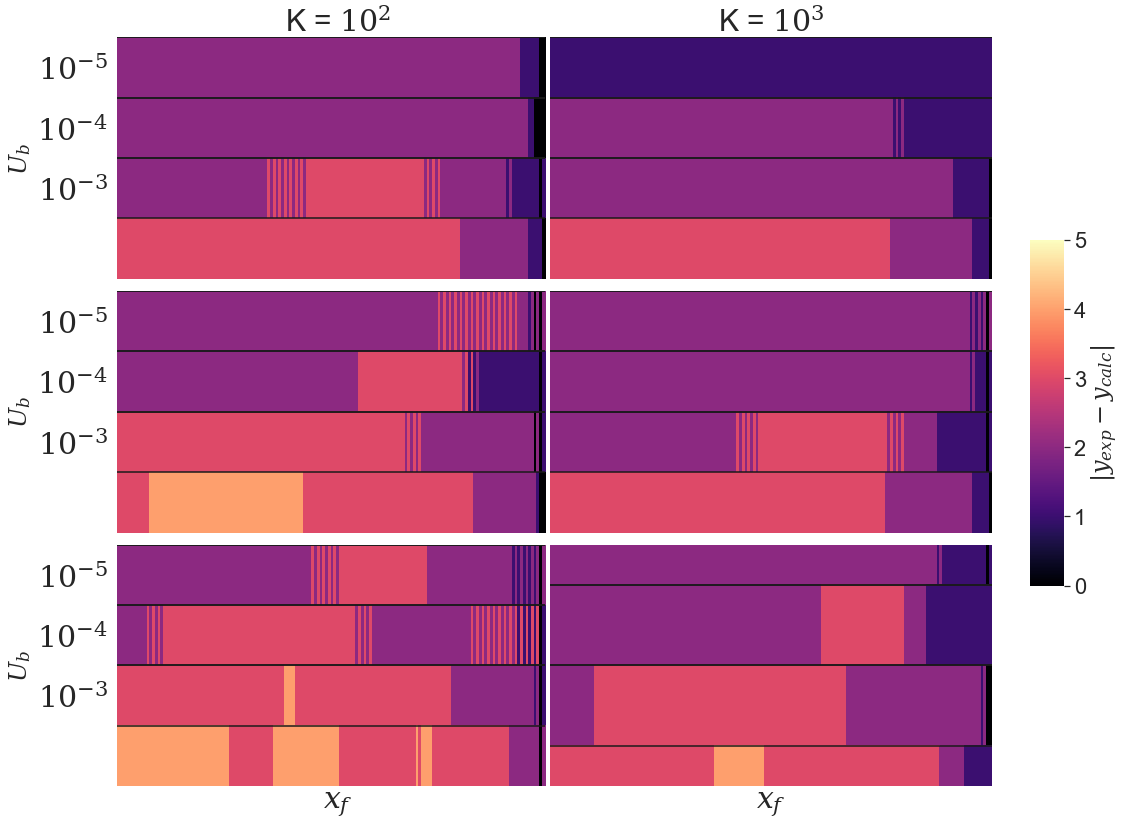

In [6191]:
##supp figure 2
mu_range =1/(10**np.array([6,5,4,3]))
s_range = [.4,.7,1]
K_range=10**np.array( [2.9,3.2])
fig,ax = plt.subplots(3,2,sharex=True,sharey=True,figsize=(16,12))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
#sns.set(font_scale=3)
sns.set_style("white")

for k,s in zip([0,0,0,1,1,1],[0,1,2,0,1,2]):
    dat= []
    print(k,s)
    for i,mu in enumerate(mu_range):

        dat.append(CII_exp[i,s,k])
    im = sns.heatmap(dat,ax=ax[s,k],cmap='magma',vmin=0,vmax=5,cbar=(k==1 and s==2),
                     cbar_ax =None if (k!=2 and s!=2) else cbar_ax) 
    ax[s,k].hlines([-1, 0],*ax[s,k].get_xlim())
    ax[s,k].hlines([0, 1],*ax[s,k].get_xlim())
    ax[s,k].hlines([2, 3],*ax[s,k].get_xlim())
    ax[s,k].hlines([1,2],*ax[s,k].get_xlim())
    #ax[s,k
    #ax[s,k].set_title([s_range[s],K_range[k]])
    
for i in [0,1]:    
    ax[-1,i].set_xticks([])
    ax[-1,i].set_xlabel('$x_f$',fontsize=30)
    ax[0,i].set_title(['K = $10^{%.1d}$' %   np.log10(K_range[i])][0],fontsize=30)
for i in [0,1,2]:
    
    #ax[i,0].set_yticks([0,1.5,3])
    ax[i,0].set_yticklabels(['$10^{%.1d}$'% i for i in [-5,-4,-3]],rotation=0,fontsize=30)
    ax[i,0].set_ylabel('$U_b$')
   

fig.tight_layout(rect=[0, 0, .9, 1])
fig.subplots_adjust(wspace=-.02)
fig.subplots_adjust(hspace=.05)
cbar_ax.set_ylabel('$|y_{exp}-y_{calc}|$')
#fig.colorbar(im,orientation='vertical',ax=ax[s,k])

In [58]:
mu=10**-2
s=1
r=.1
K=10**3.3
D=1

r = .1
x_init=100
dx =.5*(r)**.5
x = np.linspace(0,x_init-dx,x_init/dx)
b0= 1 
db0 = -.05
stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
stand[stand<0]=0

tmax=60
t_step = 1/K
t=np.linspace(0,tmax,int(tmax/t_step)+1)

R=300
dR =.5*(r)**.5
R_space = np.linspace(0,R-dR,R/dR)
n=5

b= [np.append(stand,np.zeros(len(R_space)-len(x))).tolist()]
for i in range(n-1):
    b.append(np.zeros(len(R_space)).tolist())
b=np.asarray(b)



hist = sFisher_solve(t,R_space,b,func_args =[mu,s,r,K,D])
hist=np.array(hist)

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


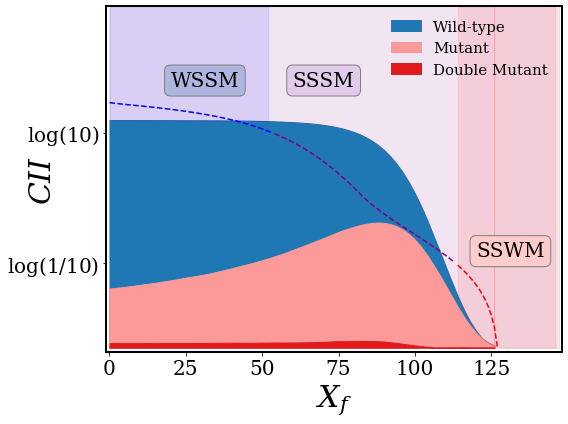

In [157]:
b_plot  = hist[int(20/t_step)]

fig,ax=plt.subplots(figsize=(8,6))
pal = sns.color_palette("Paired",12)
L_f=np.where(stand*K<1)[0][0]

f_end=np.where((np.sum(b_plot,axis=0)*K)<1)[0][0]

scale=8
CII = ((CII_calc[0,0,1]-min(CII_calc[0,0,1])) /scale )
WSSM = CII_calc[0,0,1]>np.log(10)
SSWM = CII_calc[0,0,1]<np.log(1/10)
SSSM = ~WSSM*~SSWM
colors=[pal[1],pal[4],pal[5],pal[9],pal[7],pal[11],pal[10],pal[0]]
labels  = ['Wild-type','Mutant','Double Mutant']
for i in range(3):
    ax.fill_between(range(L_f)[::2] ,np.sum(b_plot[i:],axis=0)[f_end-L_f:f_end][::2],color=colors[i],label=labels[i])
    

ax.plot(np.where(SSSM)[0],CII[SSSM],linestyle='--',color='purple')
ax.plot(np.where(SSWM)[0],CII[SSWM],linestyle='--',color='red')
ax.plot(np.where(WSSM)[0],CII[WSSM],linestyle='--',color='b')




ax.fill_between(range(L_f+20)[::2],np.sum(b_plot,axis=0)[f_end-L_f:f_end+20][::2], 1.5,color='purple',alpha=.1)
ax.fill_between(np.where(WSSM)[0][::2],np.sum(b_plot,axis=0)[f_end-L_f:f_end][WSSM][::2],1.5,color='blue',alpha=.1)
ax.fill_between(np.where(SSWM)[0][::2],np.sum(b_plot,axis=0)[f_end-L_f:f_end][SSWM][::2],1.5,color='red',alpha=.1)
ax.fill_between(range(L_f-2,L_f+20),1.5,color='red',alpha=.1)
#ax.fill_between(range(L_f-1,L_f+20)[::2],np.sum(b_plot,axis=0)[f_end-1:f_end+20][::2],1.5,color='red',alpha=.1)
    
ax.text(20,1.15,'WSSM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(.3, 0.5, 0.7,.3)))    
ax.text(120,.4,'SSWM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(1., 0.8, 0.8)))
ax.text(60,1.15,'SSSM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(.6, 0.4, 0.8,.2)))


ax.set_yticklabels('')
ax.set_xlim([-1,L_f+20])
ax.set_ylim([-.02,1.5])
for side in ['left','right','top','bottom']:
    ax.spines[side].set_linewidth(2)
ax.set_xlabel('$X_f$',fontsize=30)
ax.set_ylabel('$CII$',fontsize=30,labelpad=-50)
ax.set_yticks((np.array([-2.3,2.3]) -min(CII_calc[0,0,1])) /scale)
ax.set_yticklabels(['$\log(1/10)$','$\log(10)$'],fontsize=15)
ax.set_yticklabels(['$\log(1/10)$','$\log(10)$'],fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)
leg = ax.legend(fontsize=15)
leg.get_frame().set_alpha(0)
plt.tight_layout()
ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)
plt.savefig('fig2a.pdf',facecolor=ax.get_facecolor(), edgecolor='none' )

In [ ]:
##estimating fixation and establishment time from 'first principles'
##parameter values
mu_range =1/(10**np.linspace(4,2,41))
s_range =np.linspace(.5,5,11)
K=10**2.9
D=1
params = [mu_range,s_range,K_range,D_range]
##initialize list to store data
CII_bulk,CII_tip,CII_mix,CII_med = np.zeros((len(mu_range),len(s_range))),np.zeros((len(mu_range),len(s_range))),np.zeros((len(mu_range),len(s_range))),np.zeros((len(mu_range),len(s_range)))


c1=0
c2=0
for s in s_range:

    c1=0
    for mu in mu_range:
        r = .1
       
                
        x_init=100
        dx =.5*(r)**.5
        x = np.linspace(0,x_init-dx,x_init/dx)
        b0= 1 
        db0 = -.05
        stand = odeint(standing_wave,[b0,db0],x,args=(1,1))[:,0]
        stand[stand<0]=0
        L_f = np.where(stand*K<1)[0][0]

        dt=.0005
        rm = (s+1)*r
        L = (3.141*2) /(  (2*r**.5)*((2*s )**.5))
        G = stand[:L_f]*mu*K
        move_times = []
        for i in range(1,L_f):
            move=[]
            for j in range(i):
                move.append((G[j]) + ((((i-j)))/ (( 2*((D*(s+1))**.5)))))
            move_times.append(min(move))
        a = (( K*(1- np.array([min(1, i+ mu/K) for i in .98*stand[:L_f]]) ) )/(stand[:L_f]*K*mu)) -1
        t_est_mut = ( 1/ (stand[:L_f]*K*mu*(s+1)*r))


        t_ests=[]
        for i in range(L_f):
            t_ests.append(np.append(t_est_mut[:i],t_est_mut[i]+(x[0:L_f-i] /(((s+1)**.5 -1)*2))))

        t_ests=np.asarray(t_ests)
        minim = np.where(np.sum(t_ests,axis=1)==np.sum(t_ests,axis=1).min())[0][0]

        t_est_move = np.arange(L_f) /(((s+1)**.5 -1)*4)
        R =t_ests[minim][-1]

        #fix_count = p_surf[:,0][:L_f]*stand[:L_f]*K*mu

        t_switch = np.log((K**2-1)/(.1*(1+s)) )/ (s)

        ft =  ((x[int(L_f)]-x[:int(L_f)])/(  ((s+1)**.5 ))) 


        CII = np.log(np.array(ft)/np.array(t_ests[minim]))
        CII_tip[c1,c2]=min(CII)
        CII_bulk[c1,c2]=max(CII)
        CII_med[c1,c2] = x[L_f] - x[np.where(CII<-2.3)[0][0]]
        N=np.sum(stand[:L_f],axis=0)*K
        CII_mix[c1,c2]=np.log(N*mu*np.log(N*s))


        c1+=1
    c2+=1
    

In [7684]:
CII_med[0,0] * 2.85

34.27219101892294

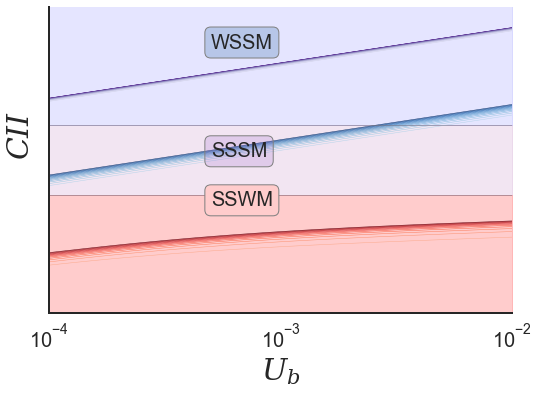

In [7661]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

mu_range =1/(10**np.linspace(4,2,41))
s_range =np.linspace(.5,5,11)
fig,ax = plt.subplots(figsize=(8,6))
colors = cm.Purples(np.linspace(.3,1,11))
for i in range(11)[::-1]:
    ax.semilogx(mu_range,CII_mix[:,i],color=colors[i],lw=.5)
    
    
    
colors = cm.Blues(np.linspace(.3,1,11))
for i in range(11)[::-1]:
    ax.semilogx(mu_range,CII_bulk[:,i],color=colors[i],alpha=1,lw=.5)
    


#plt.fill_between(range(len(CIIs_mix)),CIIs_bulk[:,-15],CIIs_bulk[:,-1], color=colors[-1],alpha=.3)
    
colors = cm.Reds(np.linspace(.3,1,11))
for i in range(11)[::-1]:
    ax.semilogx(mu_range,CII_tip[:,i],color=colors[i],alpha=1,lw=.5)
    
    
ax.set_xlim([10**-4,10**-2])
   
#plt.fill_between(mus,CIIs_tip[:,-15],CIIs_tip[:,-1], color=colors[-1],alpha=.3)
    
ax.set_yticks([-2.3,2.3])
ax.set_yticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('$CII$',fontsize=30,labelpad=100)
ax.set_xlabel(r'$U_b$',fontsize=30)
ax.text(.0005,-3,'SSWM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(1., 0.8, 0.8)))
ax.text(.0005,.2,'SSSM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(.6, 0.4, 0.8,.2)))
ax.text(.0005,7.3,'WSSM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(.3, 0.5, 0.7,.3)))
ax.yaxis.set_label_coords(-.03,.58)
ax.fill_between(mu_range,-2.3,-14,color='red',alpha=.2)
ax.fill_between(mu_range,2.3,-2.3,color='purple',alpha=.1)
ax.fill_between(mu_range,17,2.3,color='blue',alpha=.1)
ax.tick_params(axis="x", labelsize=20)
#ax.set_xticks([-1,50])
#ax.set_xticklabels([r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$'],fontsize=20)


ax.set_ylim([-10,10])

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)



ax.axhline(y=2.3,xmin=0,xmax=2,color='gray',lw=1,alpha=.5)
ax.axhline(y=-2.3,xmin=0,xmax=2,color='gray',lw=1,alpha=.5)




plt.tight_layout()
ax.patch.set_facecolor('w')
ax.patch.set_alpha(0)
#plt.savefig('fig2b.pdf',facecolor=ax.get_facecolor(), edgecolor='none' )

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so r

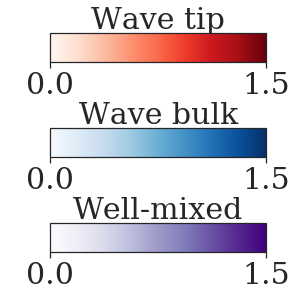

In [6176]:
fig=plt.figure()
s_range =np.linspace(.1,1,51)
ax = fig.add_axes([0, 0, 0.01, 0.01]) 
ax.grid(False)
ax.axis('off')
img = ax.imshow([s_range], cmap="Purples",vmin=0,vmax=1.5);
img.set_visible(False)
c_ax1 = fig.add_axes([0.1, 0.15, 0.5, 0.1]) 
cbar = plt.colorbar(img,orientation="horizontal",cax=c_ax1,ticks=[0,1.5]);
#cbar.ax.yaxis.set_ticks_position('left')
c_ax1.set_ylabel(r'Well-mixed', rotation=0,fontsize=30)
c_ax1.yaxis.set_label_coords(.5, .95)
c_ax1.tick_params(labelsize=30) 



ax1 = fig.add_axes([0, 0, 0.01, 0.01]) 
ax1.grid(False)
ax1.axis('off')
img1 = ax1.imshow([s_range], cmap="Blues",vmin=0,vmax=1.5);
img1.set_visible(False)
c_ax2 = fig.add_axes([0.1, 0.48, 0.5, 0.1]) 
cbar2 = plt.colorbar(img1,orientation="horizontal",cax=c_ax2,ticks=[0,1.5]);
cbar2.ax.yaxis.set_ticks_position('left')
c_ax2.set_ylabel(r'Wave bulk', rotation=0,fontsize=30)
c_ax2.yaxis.set_label_coords(.5, .95)
c_ax2.tick_params(labelsize=30) 


ax2 = fig.add_axes([0, 0, 0.01, 0.01]) 
ax2.grid(False)
ax2.axis('off')
img2 = ax2.imshow([s_range], cmap="Reds",vmin=0,vmax=1.5);
img2.set_visible(False)
c_ax3 = fig.add_axes([0.1, 0.81, 0.5, 0.1]) 
cbar3 = plt.colorbar(img2,orientation="horizontal",cax=c_ax3,ticks=[0,1.5]);
cbar3.ax.yaxis.set_ticks_position('left')
c_ax3.set_ylabel(r'Wave tip', rotation=0,fontsize=30)
c_ax3.yaxis.set_label_coords(.5, .95)
c_ax3.tick_params(labelsize=30) 
ax1.patch.set_facecolor('w')
ax1.patch.set_alpha(0)
plt.tight_layout()
plt.savefig('fig2bars.pdf',facecolor=ax1.get_facecolor(), edgecolor='none')


In [1236]:
D= 1 
K =1*10**5
rw=.05
R=500
aas = np.linspace(1.2,4.1,50)
mus = np.linspace(10**-8,10**-2,50)

CIIs_bulk= np.zeros((len(aas),len(mus)))
CIIs_tip = np.zeros((len(aas),len(mus)))
CIIs_mix = np.zeros((len(aas),len(mus)))

c1=0
c2=0
for a in aas:
    c1=0
    for mu in mus:

        stand = odeint(standing_wave,[1,-.000000001],np.linspace(0,R-1,R),args=(D,rw))
        p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .0001)
        L_f = np.where((stand[:,0]*K)>1)[0][-1]


        fix_count = p_surf[:,0][:L_f]*stand[:,0][:L_f]*K*mu
        f_e = np.where(fix_count==max(fix_count))[0][0]
        calc_est_times =1/max(fix_count)

        calc_fix_times = []
        for i in range(L_f):
            ft = ((2*L_f-i-f_e)/ ( 2*((D*rm)**.5))-(2*((D*rw)**.5)))
            calc_fix_times.append(ft)


        N = sum(stand[:,0][:L_f])*K
        CII_bulk = np.log(calc_fix_times[0]/calc_est_times)

        CII_tip = np.log(calc_fix_times[-1]/calc_est_times)

        CII_mix = np.log(np.log((a-1)*rw*N)*(N *mu) )

        CIIs_bulk[c1,c2]= CII_bulk
        CIIs_tip[c1,c2]=CII_tip
        CIIs_mix[c1,c2]=CII_mix
        
        c1+=1
    c2+=1



array([6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5, 5, 5,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2])

In [859]:
##save simulation results
#np.save('CII_exp.npy', np.array(CII_exp))

In [6185]:
##load simulation results
CII_exp = np.load('CII_exp.npy')

In [6186]:
CII_exp=np.array(CII_exp).reshape(4,3,2,1)

Here we introduce a Clonal Interference Index (CII), derived from the relative proportions of mutant fixation and establishment times. We caluculate this over a range of parameters, and compare to our simulations.

In [881]:
##estimating clonal inference for evolution of multiple competing mutant waves
##parameter values
mu_range =1/(10**np.array([5,4,3]))
s_range = [.1,.15,.2]
K_range=10**np.array( [2,3,4])
D_range=[1]
params = [mu_range,s_range,K_range,D_range]

#initialize list to store data
CIIs=[]
for a,mu in enumerate(mu_range):
    for b,s in enumerate(s_range):
        for c,K in enumerate(K_range):
            for d,D in enumerate(D_range):
                ##solve to find initial wild-type wave
                x = np.linspace(0,99,100)
                r = .1
                b0= 1 
                db0 = -.005
                stand = odeint(standing_wave,[b0,db0],x,args=(D,r))[:,0]
                L_f = np.where(stand*K<1)[0][0]

                #find surfing probability for a lone mutant
                rm=r+s
                L = (2*3.141) /( 2*((D*(rm))**.5) * (2*(rm/r -1))**.5)
                dudx = rm*((D*(rm))**.5)*np.exp(-L)
                p_surf = surf_prob_solve(stand,r,rm,D, dudx)
                
                
                est_time_x =1/(stand[:L_f]*K*mu)
                R = np.mean(p_surf[:,0])*np.mean(stand)*K*mu
                est_time=1/R
                fix_count = p_surf[:,0][:L_f]*stand[:L_f]*K*mu
                x_max = np.where(fix_count == max(fix_count))[0][0]


                calc_fix_times=[]

                for i in range(L_f):
                    ft = (((L_f-i)+(L_f-x_max))/ ( 2*((D*(s+r))**.5)-2*((D*(r))**.5) ))  +est_time/r
                    fix_time =ft/2
                CII=np.log(fix_time/est_time_x)
                
                ##record data
                CIIs.append(CII)


    
                

0
0
0
1
1
1
2
2
2
0
0
0
1
1
1
2
2
2
0
0
0
1
1
1
2
2
2


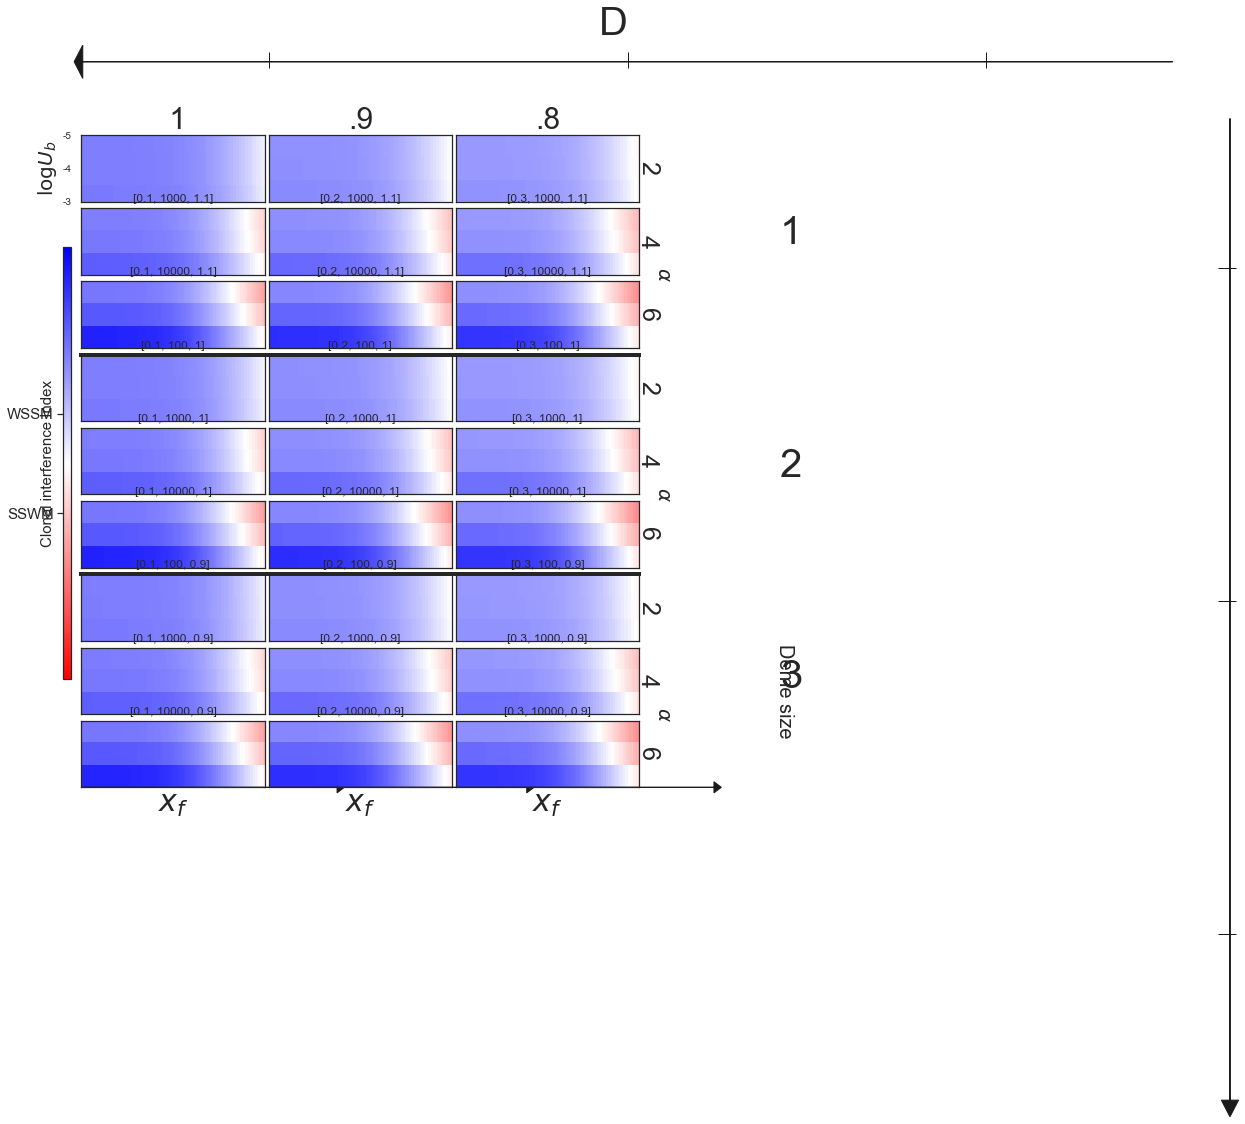

In [287]:
fig, axs = plt.subplots(9,3,figsize=(10,12))

for ax,l,j,k in zip(axs.flat,9*np.array(range(3)).tolist(),np.array([[3*[i] for i in range(3)]*3 for j in range(3)]).flatten(),np.array([[9*[i] for i in range(3)]]*3).flatten()):     
    print(j)
    m = ax.imshow(CIIs[:,l,j,k].tolist(),vmin=-10,vmax=10,cmap='bwr_r',aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title([s_range[l],K_range[j],D_range[k]])
    
    
cbar_ax = fig.add_axes([0.1, 0.25, 0.01, 0.5])
cbar = fig.colorbar(m, cax=cbar_ax,ticks= [-2.3,2.3])
cbar.set_label('Clonal interference Index', rotation=90,fontsize=15,labelpad=-30)
cbar_ax.set_yticklabels(['SSWM','WSSM'],fontsize=15)
cbar_ax.yaxis.set_ticks_position('left')

    
plt.subplots_adjust(wspace=.02)
plt.subplots_adjust(hspace=.1)



axs[0,0].set_yticks([0,1,2])
axs[0,0].set_yticklabels([-5,-4,-3],fontsize=10)
axs[0,0].set_ylabel(r'$\logU_b$',fontsize=20,rotation=90)


for i in [0,1,2]:
    axs[0+3*i,-1].set_ylabel('2',fontsize=25,labelpad=-180,rotation=270)
    axs[1+3*i,-1].set_ylabel('4',fontsize=25,labelpad=-180,rotation=270)
    axs[2+3*i,-1].set_ylabel('6',fontsize=25,labelpad=-180,rotation=270)

    axs[1+3*i,-2].set_ylabel(r'$\alpha$',fontsize=20,rotation=270,labelpad=50)
    axs[1+3*i,-2].yaxis.set_label_coords(2.1, 0)

axs[0+4*0,-1].set_ylabel('2',fontsize=25,labelpad=-180,rotation=270)

axs[0,0].text(180,-3,'D',fontsize=40)
axs[0,0].set_title(' 1',fontsize=30)
axs[0,1].set_title('.9',fontsize=30)
axs[0,2].set_title('.8',fontsize=30)


ax.text(132,-22,1,fontsize=40)
ax.text(132,-11.5,2,fontsize=40)
ax.text(132,-2,3,fontsize=40)


ax.text(130,.1,'Deme size',fontsize=20,rotation=270)

axs[0,0].arrow(400,-.5,0,29.5,head_width =6,head_length= .5,clip_on=False,color = 'k')
axs[0,0].arrow(396,4,6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(396,14,6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(396,24,6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')


axs[0,0].arrow(380,-2.2,-380,-0,head_width =1,head_length= 3,clip_on=False,color = 'k')
axs[0,0].arrow(65,-2,0,-.5,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(190,-2,0,-.5,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(315,-2,0,-.5,head_width =0,head_length= 0,clip_on=False,color = 'k')


for i in [0,1,2,]:
    axs[-1,i].set_xlabel(r'$x_{f}$',fontsize=30)
    
axs[-1,0].arrow(0,2.5,104,0,head_width=.5,head_length=3,clip_on=False,color = 'k')
axs[-1,1].arrow(0,2.5,105,0,head_width=.5,head_length=3,clip_on=False,color = 'k')
axs[-1,2].arrow(0,2.5,105,0,head_width=.5,head_length=3,clip_on=False,color = 'k')



for i in[0,1,2]:
    for j in range(np.prod(CIIs.shape[:2]))[::3][1:]:
        axs[j,i].spines['top'].set_linewidth(4)

#plt.savefig('CII_map.pdf')

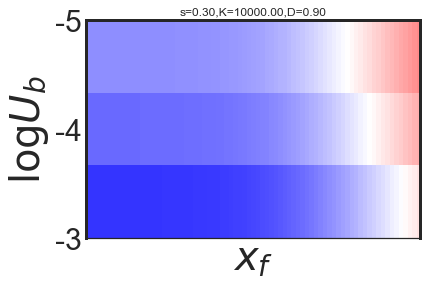

In [331]:
fig, ax = plt.subplots(figsize=(6,4))


m = ax.imshow(CIIs[:,-1,-1,-1].tolist(),vmin=-10,vmax=10,cmap='bwr_r',aspect='auto')
ax.set_xticks([])




ax.set_yticks([-.5,1,2.5])
ax.set_yticklabels([-5,-4,-3],fontsize=30)
ax.set_ylabel(r'$\logU_b$',fontsize=40)
ax.set_xlabel(r'$x_{f}$',fontsize=40)
#ax.arrow(0,2.5,124,0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=3)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_title('s=%.2f,K=%.2f,D=%.2f'%(s_range[-1],K_range[-1],D_range[-1]))
ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
#plt.subplots_adjust(wspace=.05)
#plt.subplots_adjust(hspace=.1)
#plt.tight_layout()


### local mutant fixation time at wave tip over parameter space 

In [9]:
#### solve fisher equation,  measure time for front to fix with 1 mutant
###equation parameters
R= 5000
R_div = 1
c=.0028
c_0=.000035
c_1=.0028
delta= 0
I = 0
K_x = 0
K_s = 0
N = 0
H = 0
rw = .1
a = 1.3
K= (1*10**7)
b0 = np.exp( -(np.linspace(0,R-1,R)**2)/(2**2))
s0 = np.full(R,1)
t = t=np.linspace(0,100,1000)

bm0 = np.zeros((R-1)*R_div+1)
z  = np.concatenate([b0,bm0,s0])##initial conditions for wild type (gaussian packet), mutant (0), and substrate (1)


cs = [.0015,.00275,.00279,.00281] ## diffusion constants in terms of agar concentration
mus = np.array([.000001,.00001,.0001,.001]) ##mutation rates (Ub inpre print)
ss = np.array([1.5,3,4.5,6]) ## selection coefcients (alphha in preprint)
ft_param = []
results_param = []
for c in cs:
    for mu in mus:
        for a in ss:
            results = []
            results.append(z)
            dt = .1

            fixed = False
            t= 0
            fix_times=[]
            
            ##solve for standing wave which will define wave front 
            stand = odeint(standing_wave,[1,-.01],np.linspace(0,99,100),args=(M_A(c,.000035,.0028,1),rw))
            L_f = np.where((stand[:,0]*K)>1)[0][-1]
            fb_1 =np.zeros(L_f)==1
            
            
            ### run simulation until the wave front fixes 
            while not fixed:
                results.append(results[-1] +dt*model_sde_1mut(results[-1], t,R,R_div,c,c_0,c_1,delta,I,K_x,K_s,N,H,rw,a,mu,K))
                results[-1][results[-1]< 0]= 0  
                #wild type and mutant waves 
                b = results[-1][0:R] 
                bm = results[-1][R:2*R]
                
                #end of wave front
                fe= np.where(((b+bm)*K)>1)[0][-1]
                
                if fe >=L_f:
                        #start of wave front
                    fs=fe-L_f


                    front_bools = ((b[fs:fe]*K)<1)
                    ##update fixation times  times
                    fix_times.append((fb_1^front_bools)*t)
                    fb_1 = front_bools
                    fixed = all(front_bools)



                t+=1
                #limit for how long simulation would run 
                if t ==15000:
                    fixed =True
                    
                
            ft =np.array(fix_times)
            ft_param.append(ft[:,:].max(axis=0))
            results_param.append(results)

In [94]:
##arange data in arrays 
ft=np.array(ft_param).flatten()
f0 =  np.array((ss.tolist())*16).flatten()
f =  np.array([[f0[i]]*len(ft[i]) for i in range(len(ft))]).flatten()
m0 = np.array([4*[i] for i in mus]*4).flatten()
m =  np.array([[m0[i]]*len(ft[i]) for i in range(len(ft))]).flatten()
c0 = np.array([16*[i] for i in cs]).flatten()
c =  np.array([[c0[i]]*len(ft[i]) for i in range(len(ft))]).flatten()

In [95]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [96]:
#place data in dta frame
df=pd.DataFrame(dict(t = flatten(ft),f=flatten(f),m=flatten(m),c=flatten(c)))

In [97]:
##find minimum of data once normalized to the first position (x_f = 0) in the wave front for the purposes of scaling colormap 
mins = []
for f in df['f'].unique():
    for m in df['m'].unique():
        for c in df['c'].unique():
            row = df['t'][df['f'] == f][df['m'] == m][df['c'] == c]
            mins.append(row.min()/row.max())
            
min_norm = min(mins)

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anacon

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anacon

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/nikhilkrishnan/anacon

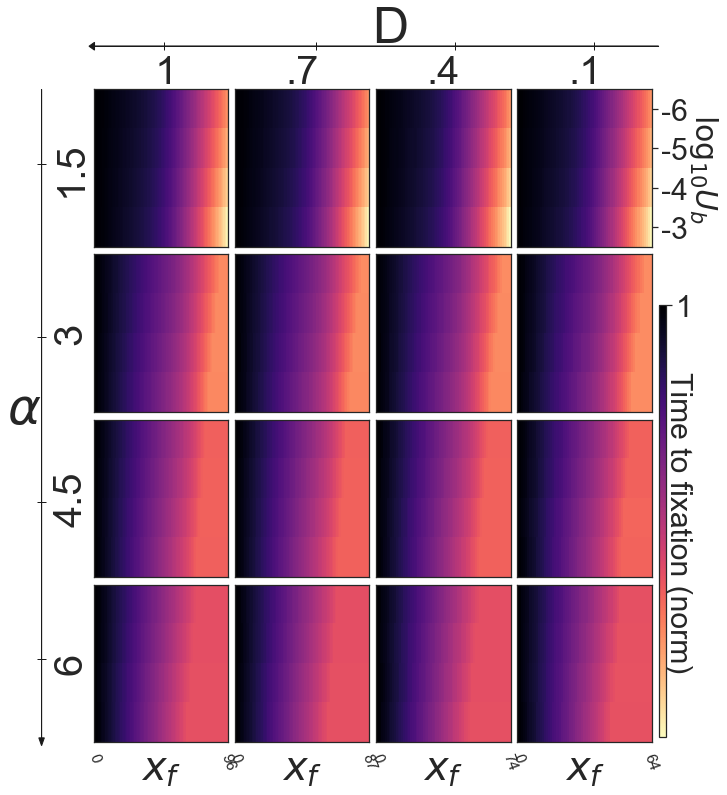

In [98]:
##Figure 1b 

fig,axs = plt.subplots(4,4,figsize =(10,12))
current_cmap = 'magma_r'
c_list = df['c'].unique().tolist()*4
f_list = np.array([4*[i] for i in df['f'].unique().tolist()]).flatten()
barc= 0 

for a,f in zip(axs, df['f'].unique()):
    for b,c in zip(range(len(a)),df['c'].unique()):
        dat= []
        for i in df['m'].unique():
            dat.append(df[df['f']==f][df['c']==c][df['m']==i]['t']/max(df[df['f']==f][df['c']==c][df['m']==i]['t']))
            a[b].imshow(dat,aspect="auto",vmin=min_norm,vmax=1,cmap=current_cmap)
        a[b].set_yticks([])
        a[b].set_xticks([])
        


plt.subplots_adjust(wspace=.05)
plt.subplots_adjust(hspace=.05)

##adjust color bar 
hm = a[b].imshow(dat,aspect="auto",vmin=min_norm,vmax=1,cmap=current_cmap)
cbar_ax = fig.add_axes([.91, 0.13, 0.01, 0.5])
cbar = fig.colorbar(hm, cax=cbar_ax,ticks=[round(min_norm,1)-.1, 1])
cbar.ax.tick_params(labelsize=30) 
cbar.set_label('Time to fixation (norm)', rotation=270,fontsize=30,labelpad=0)

###D sxis text and arrows 
axs[0,0].text(200,-1.7,'D',fontsize=50)
axs[0,0].set_title(' 1',fontsize=40)
axs[0,1].set_title('.7',fontsize=40)
axs[0,2].set_title('.4',fontsize=40)
axs[0,3].set_title('.1',fontsize=40)
axs[0,0].arrow(407,-1.60,-407,-0,head_width =.2,head_length= 4,clip_on=False,color = 'k')
axs[0,0].arrow(50,-1.5,0,-.2,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(160,-1.5,0,-.2,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(260,-1.5,0,-.2,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(360,-1.5,0,-.2,head_width =0,head_length= 0,clip_on=False,color = 'k')


## a axis text 
axs[0,0].text(-63,8,r'$\alpha$',fontsize=50)
axs[0,0].set_ylabel('1.5',fontsize=40)
axs[1,0].set_ylabel('3',fontsize=40)
axs[2,0].set_ylabel('4.5',fontsize=40)
axs[3,0].set_ylabel('6',fontsize=40)
axs[0,0].arrow(-38.2,-.5,0,16.5,head_width =4,head_length= .2,clip_on=False,color = 'k')
axs[0,0].arrow(-35.3,1.4,-6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(-35.3,5.8,-6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(-35.3,10,-6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(-35.3,14,-6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')

## U axis text 
axs[0,3].yaxis.tick_right()
axs[0,3].set_yticks([0,1,2,3])
axs[0,3].set_yticklabels([-6,-5,-4,-3],fontsize=30)
axs[0,3].set_ylabel(r'$\log_{10}U_b$',fontsize=30,rotation=270,labelpad=-170)

# bottom x tick and label axes text 
axs[-1,0].set_xticks([0,len(ft[0])-1])
axs[-1,0].set_xticklabels(['0','%d'% int(len(ft[0])-1) ],fontsize=15,rotation=290)
axs[-1,1].set_xticks([0,len(ft[17])-1])
axs[-1,1].set_xticklabels(['0','%d'% int(len(ft[17])-1) ],fontsize=15,rotation=290)
axs[-1,2].set_xticks([0,len(ft[33])-1])
axs[-1,2].set_xticklabels(['0','%d'% int(len(ft[33])-1) ],fontsize=15,rotation=290)
axs[-1,3].set_xticks([0,len(ft[49])-1])
axs[-1,3].set_xticklabels(['0','%d'% int(len(ft[49])-1) ],fontsize=15,rotation=290)
axs[-1,0].set_xlabel(r'$x_{f}$',fontsize=40,labelpad=-20)
axs[-1,1].set_xlabel(r'$x_{f}$',fontsize=40,labelpad=-20)
axs[-1,2].set_xlabel(r'$x_{f}$',fontsize=40,labelpad=-20)
axs[-1,3].set_xlabel(r'$x_{f}$',fontsize=40,labelpad=-20)


#plt.savefig('grid_norm.pdf')

### demonstrating clonal interference index w.r.t. position along wave profile 

In [3050]:
R= 500
t=np.linspace(0,1000,10000)
D=M_A(.00272,.000035,.0028,1)
K =1*10**4
a =2.5
mu = 10**-5
rw=.1
stand = odeint(standing_wave,[1,-.001],np.linspace(0,R-1,R),args=(D,rw))
p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .001)
L_f = np.where((stand[:,0]*K)>1)[0][-1]
sim_sde_2 = sde_model_solve_2mut(R=R, R_div=1,
                          c=.00272,c_0=.000035,c_1=.0028,
                          delta= 0,I = 0,
                          K_x = 0, K_s = 0,N = .0, H = 0,rw=rw,
                          a = a,mu = mu,
                          b0 = np.exp( -(np.linspace(0,R-1,R)**2)/(2**2)),
                                 s0 = np.full(R,1),t = t,L_f=L_f, K = K )

In [3055]:
fix_count = p_surf[:,0][:L_f]*stand[:,0][:L_f]*K*mu
f_e = np.where(fix_count==max(fix_count))[0][0]
calc_est_times =1/max(fix_count)

In [3056]:
rm=rw*a
calc_fix_times = []
for i in range(L_f):
    ft = ((2*L_f-i-f_e))/ ((2*((D*rm)**.5) - 2*((D*rw)**.5)))
    calc_fix_times.append(ft)
    

In [3057]:
fix_count

array([0.00000000e+00, 7.30201718e-05, 1.10533370e-04, 1.29748378e-04,
       1.39524207e-04, 1.44428274e-04, 1.46820434e-04, 1.47920821e-04,
       1.48360614e-04, 1.48467166e-04, 1.48410165e-04, 1.48278958e-04,
       1.48120909e-04, 1.47962144e-04, 1.47817965e-04, 1.47697594e-04,
       1.47608591e-04, 1.47558162e-04, 1.47552553e-04, 1.47597515e-04,
       1.47701339e-04, 1.47871729e-04, 1.48118918e-04, 1.48453554e-04,
       1.48888156e-04, 1.49437229e-04, 1.50117152e-04, 1.50946551e-04,
       1.51946922e-04, 1.53142233e-04, 1.54559500e-04, 1.56231064e-04,
       1.58195458e-04, 1.60496249e-04, 1.63181832e-04, 1.66306429e-04,
       1.69929344e-04, 1.74124426e-04, 1.78972361e-04, 1.84565449e-04,
       1.91006521e-04, 1.98409455e-04, 2.06899822e-04, 2.16613998e-04,
       2.27704503e-04, 2.40328420e-04, 2.54645413e-04, 2.70813043e-04,
       2.88977059e-04, 3.09261597e-04, 3.31745647e-04, 3.56445830e-04,
       3.83287225e-04, 4.12074207e-04, 4.42448683e-04, 4.73853363e-04,
      

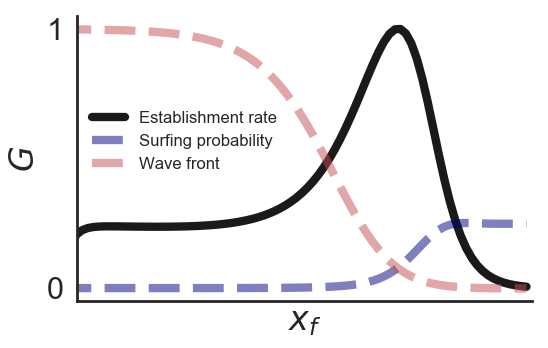

In [3061]:

fig, ax1 = plt.subplots(figsize=(6,4))
sns.set(font_scale=2)
sns.set_style("white")
ax1.set_xticks([])
ax1.set_yticks([0,1])
ax1.set_yticklabels([0,r'1'])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.set_xlim(3,L_f)

#ax2.set_ylabel('$b$',color ='r')

ax1.set_xlabel('$x_f$')
ax1.set_ylabel(r'$G$')
ax1.plot(fix_count/max(fix_count),lw=6,label = 'Establishment rate',color= 'k')

ax1.plot(p_surf[:,0][:L_f],lw=6,label = 'Surfing probability',color= 'navy',linestyle='--',alpha=.5)

ax1.plot(stand[:,0][:L_f],linestyle='--',lw =6, label = 'Wave front',alpha= .5,color = 'r')
leg = ax1.legend(loc=3, prop={'size': 12},bbox_to_anchor=(0, .4))
leg.get_frame().set_edgecolor((1,1,1,0))
leg.get_frame().set_linewidth(0)
plt.tight_layout()
plt.savefig('est_rate.pdf')

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


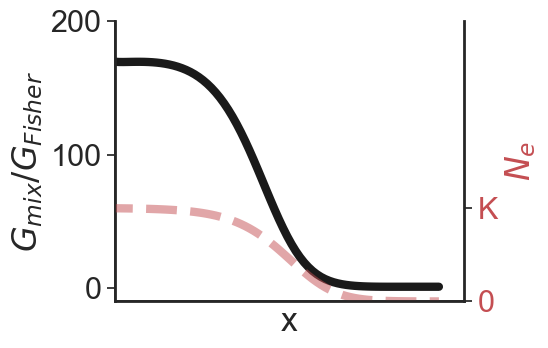

In [3064]:

fig, ax1 = plt.subplots(figsize=(6,4))
sns.set(font_scale=2)
sns.set_style("white")
ax1.set_xticks([])
#ax1.set_yticks([0,1])
#ax1.set_yticklabels([0,r'1'])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


#ax2.set_ylabel('$b$',color ='r')

ax1.set_xlabel('x')
ax1.set_ylabel(r'$G_{mix}/G_{Fisher}$')



est_rate_ratio = (np.array(stand[:,0][:L_f]*max(p_surf[:,0][:L_f])*K*mu)/np.array(fix_count))[5:L_f]

ax1.plot(est_rate_ratio,lw=6,color='k')


ax1.set_ylim(-10,200)
ax2=ax1.twinx()
ax2.plot(stand[:,0][:L_f][5:L_f]-1,linestyle='--',lw =6, label = 'Wave front',alpha= .5,color = 'r')

ax2.set_ylim(-1,2)
ax2.set_xlim(3,L_f)
ax2.set_yticks([-1,0])
ax2.set_yticklabels([0,'K'])


ax2.set_ylabel(r'$N_e$',color='r')
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)

#ax2_Set.yticks(ticks, [labels], **kwargs)
ax2.tick_params(axis='y', labelcolor='r')
#ax1.plot(stand[:,0][:L_f]/max(est_rate_ratio),linestyle='--',lw =6, label = 'Wave front',alpha= .5,color = 'r')
#leg = ax1.legend(loc=3, prop={'size': 12},bbox_to_anchor=(0, .4))
#leg.get_frame().set_edgecolor((1,1,1,0))
#leg.get_frame().set_linewidth(0)
plt.tight_layout()
plt.savefig('est_rate_ratio.pdf')

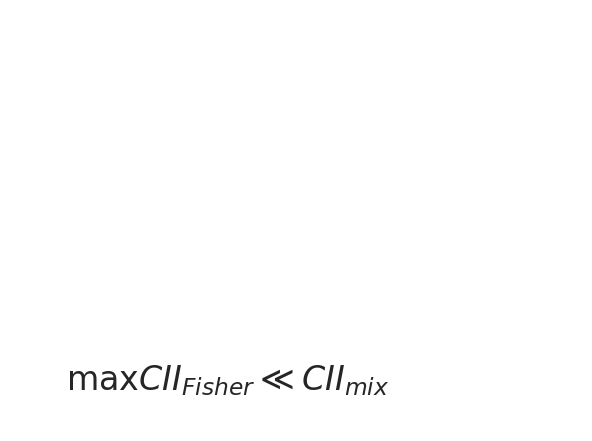

In [3065]:
fig,ax = plt.subplots()
ax.axis('off')

ax.text(0,0,r'$\maxCII_{Fisher} \ll CII_{mix}$')
plt.savefig('mix_text.pdf')

In [3066]:
s= .25-.1

fix = 1/s * np.log(sum(stand[:,0][:L_f])*s)

est = 1/ (N*mu*s)

np.log(fix/est)

6.0228993154265975

In [3067]:
fixf = (2*L_f-f_e)/ (2*((.25)**.5-(.1)**.5))

In [3068]:
fixe = 1/ (max(stand[:,0][:L_f]*p_surf[:,0][:L_f])*K*mu)

In [3069]:
np.log(fixf/fixe)

-1.684081681301772

In [3070]:
CII =np.log(calc_fix_times/calc_est_times)

In [3071]:
np.log(.01)

-4.605170185988091

In [3072]:
CII

array([-1.63565383, -1.64478631, -1.65400297, -1.66330536, -1.6726951 ,
       -1.68217384, -1.6917433 , -1.70140521, -1.71116138, -1.72101368,
       -1.73096401, -1.74101434, -1.75116672, -1.76142322, -1.771786  ,
       -1.7822573 , -1.79283941, -1.8035347 , -1.81434562, -1.82527469,
       -1.83632452, -1.84749782, -1.85879738, -1.87022608, -1.8817869 ,
       -1.89348294, -1.9053174 , -1.91729359, -1.92941495, -1.94168504,
       -1.95410756, -1.96668634, -1.97942537, -1.99232877, -2.00540085,
       -2.01864608, -2.0320691 , -2.04567475, -2.05946808, -2.07345432,
       -2.08763895, -2.10202769, -2.11662649, -2.13144158, -2.14647945,
       -2.16174692, -2.17725111, -2.19299947, -2.20899981, -2.22526033,
       -2.24178963, -2.25859675, -2.27569118, -2.29308293, -2.3107825 ,
       -2.32880101, -2.34715015, -2.36584228, -2.38489048, -2.40430856,
       -2.42411119, -2.4443139 , -2.46493318, -2.48598659, -2.5074928 ,
       -2.5294717 , -2.55194456, -2.57493408, -2.59846458, -2.62

In [3073]:
SSWM = np.where((np.log(calc_fix_times/calc_est_times)>-3))[0][-1]

In [3074]:
SSWM

81

In [3075]:
L_f

86

In [3076]:
switch = SSWM-10

In [3077]:
g_rng = L_f-switch

In [3078]:
r_space= np.linspace(0,R-1,R)
t_graph = [1500,1600,1700,1800,1900]
x = []
xm = []
xm2 = []

for t in t_graph:
    x0 = sim_sde_2[t][0:R]+sim_sde_2[t][R:2*R] +sim_sde_2[t][2*R:3*R]
    xm0 = sim_sde_2[t][R:2*R] +sim_sde_2[t][2*R:3*R]
    xm20= sim_sde_2[t][2*R:3*R]


    x.append(x0[(x0*K)>1][-g_rng:])
    xm.append(xm0[(x0*K)>1][-g_rng:])
    xm2.append(xm20[(x0*K)>1][-g_rng:])

In [3079]:
c = CII[switch:].tolist()*len(t_graph)
r = [np.linspace(0,g_rng-1,g_rng).tolist()]*len(t_graph)
t=  [[t]*g_rng for t in t_graph]

In [3080]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [3081]:
CII_rep = {}
CII_rep['x'] = flatten(np.array(x))
CII_rep['xm'] = flatten(np.array(xm))
CII_rep['xm2'] = flatten(np.array(xm2))
CII_rep['r'] = flatten(np.array(r))
CII_rep['t'] = flatten(np.array(t))
CII_rep['c'] = np.array(c)
df = pd.DataFrame(CII_rep)

In [3082]:
g_rng

15

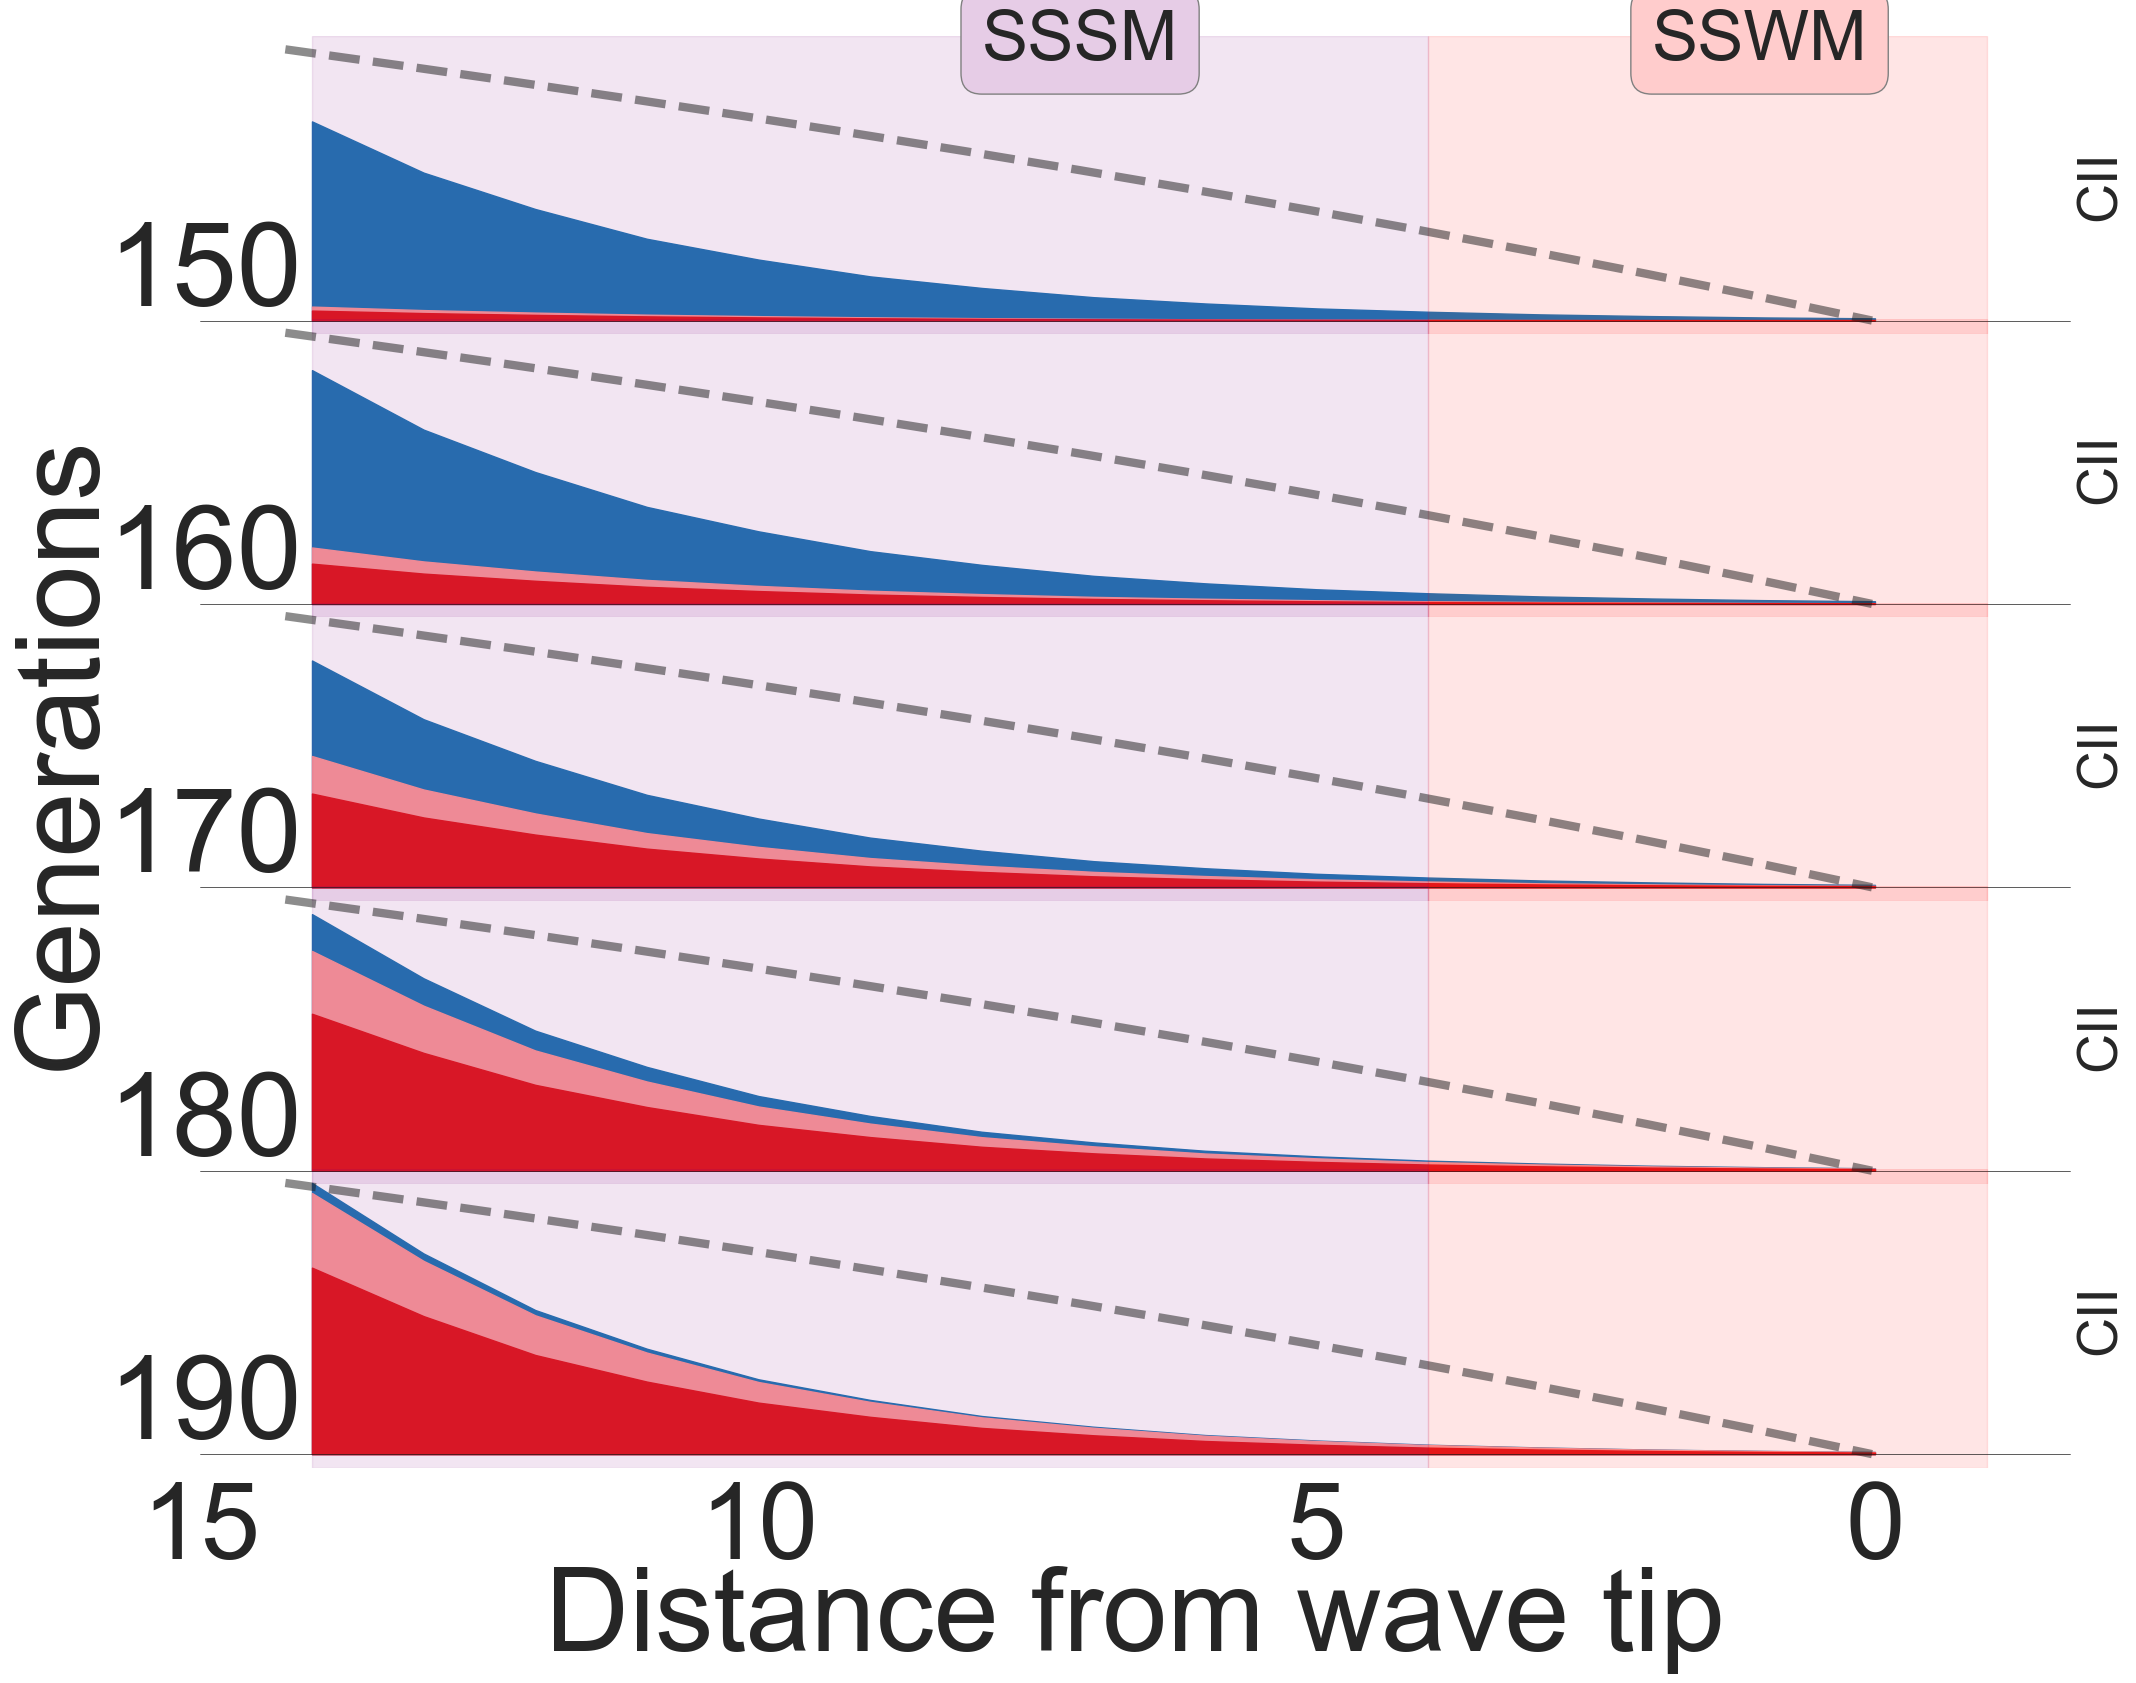

In [3105]:
#r_space[(grad(df['x'])<-.001)[0:R]]
#df = df[grad(df['x'])<-.001]


sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=7)

#rep CII
# Initialize the FacetGrid objects

pal = sns.color_palette("Paired",10)
g = sns.FacetGrid(df, row="t",hue= "t" ,aspect=6, height=4 )

g.map(plt.fill_between,"r","x",clip_on=False,color = pal[1], label = 'Wild-type')
g.map(plt.fill_between,"r","xm",clip_on=False,color = pal[4], label = 'Mutant')
g.map(plt.fill_between,"r","xm2",clip_on=False,color = pal[5], label = 'Mutant')


g.map(plt.axvspan,xmin=0, xmax=10, alpha=0.1, color='purple')
g.map(plt.axvspan,xmin=10, xmax=g_rng, alpha=0.1, color='red')

#g.map(plt.plot,"r","x",clip_on=False,color= 'k')
#g.map(plt.plot,"r","xm",clip_on=False,color= 'k')
#g.map(plt.fill_between,"r","xm2",clip_on=False,color = pal[9], label = 'Double Mutant')
g.map(plt.axhline,y=0,lw=.5,clip_on=False,color='k')


# Define and use a simple function to label the plot in axes coordinates
def label(x,color,label):
    ax = plt.gca()
    ax.text(-.05, .2, int(int(label)/10),
            ha="left", va="center", transform=ax.transAxes)

def facetgrid_two_axes(*args, **kwargs):
    kwargs.pop('color')
    data = kwargs.pop('data')
    dual_axis = kwargs.pop('dual_axis')
    ax = plt.gca()
    alpha = kwargs.pop('alpha', 0.5)
    if dual_axis:
        ax2 = ax.twinx()
        ax2.set_yticks([-2.3])
        ax2.set_yticklabels(['0'],fontsize=30)
        ax2.set_ylabel('CII',fontsize=40)
        #ax2.axhline(y=0,xmin=0,xmax=fe,color = 'k',alpha=.5)
        


    if dual_axis:
        ax2.plot(data['r'],data['c'],color = 'k', linewidth= 6,**kwargs,alpha=alpha,linestyle='dashed')

    
        
        
g.map_dataframe(facetgrid_two_axes, dual_axis=True)
g.map(label,'x')
#g.map(plt.xlim,xmin=10,xmax=50)
g.fig.subplots_adjust(hspace=-.05)
g.set_titles("")

g.set(yticks=[])
g.set(xticks=[-1,4,9,14])
g.set(xticklabels=[15,10,5,0])
g.set_ylabels("")

g.despine(bottom=True, left=True)


ax = g.facet_axis(-3,0)
ax.set_ylabel('Generations',labelpad=60)

ax = g.facet_axis(-1,0)
ax.set_xlabel('Distance from wave tip',labelpad=-10)
#ax.text(13,2,'CII',rotation=270)

ax = g.facet_axis(0,-1)
ax.text(12,.013, 'SSWM',fontsize=50,bbox=dict(boxstyle="round",ec='grey',fc=(1., 0.8, 0.8)))
ax.text(6,.013, 'SSSM',fontsize=50,bbox=dict(boxstyle="round",ec='grey',fc=(.9, 0.8, 0.9)))
plt.savefig('CI.pdf')

In [1769]:
R= 500
t=np.linspace(0,1000,10000)
D=M_A(.00272,.000035,.0028,1)
K =1*10**5
a =2.5
mu = 10**-4.5
rw=.1
stand = odeint(standing_wave,[1,-.000000000138],np.linspace(0,R-1,R),args=(D,rw))
p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .001)
L_f = np.where((stand[:,0]*K)>1)[0][-1]
sim_sde_2 = sde_model_solve_2mut(R=R, R_div=1,
                          c=.00272,c_0=.000035,c_1=.0028,
                          delta= 0,I = 0,
                          K_x = 0, K_s = 0,N = .0, H = 0,rw=rw,
                          a = a,mu = mu,
                          b0 = np.exp( -(np.linspace(0,R-1,R)**2)/(2**2)),
                                 s0 = np.full(R,1),t = t,L_f=L_f, K = K )

In [1780]:
L_f

301

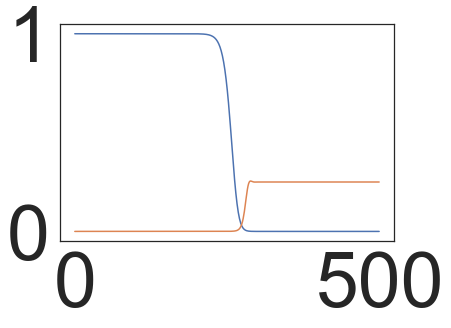

In [1770]:
stand = odeint(standing_wave,[1,-.000000000138],np.linspace(0,R-1,R),args=(D,rw))
p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .0001)

plt.plot(stand[:,0])
plt.plot(p_surf[:,0])

In [1771]:
fix_count = p_surf[:,0][:L_f]*stand[:,0][:L_f]*K*mu
f_e = np.where(fix_count==max(fix_count))[0][0]
calc_est_times =1/max(fix_count)

In [1772]:
rm=rw*a
calc_fix_times = []
for i in range(L_f):
    ft = ((2*L_f-i-f_e))/ ((2*((D*rm)**.5) - 2*((D*rw)**.5)))
    calc_fix_times.append(ft)
    

In [1773]:
CII =np.log(calc_fix_times/calc_est_times)

In [1777]:
np.log(.1)

-2.3025850929940455

In [1774]:
CII

array([ 1.13786556,  1.13480277,  1.13173057,  1.12864891,  1.12555771,
        1.12245694,  1.11934651,  1.11622639,  1.11309649,  1.10995677,
        1.10680717,  1.1036476 ,  1.10047803,  1.09729838,  1.09410858,
        1.09090858,  1.0876983 ,  1.08447769,  1.08124667,  1.07800517,
        1.07475314,  1.07149049,  1.06821717,  1.06493309,  1.0616382 ,
        1.05833241,  1.05501566,  1.05168787,  1.04834896,  1.04499888,
        1.04163753,  1.03826485,  1.03488075,  1.03148516,  1.028078  ,
        1.02465919,  1.02122866,  1.01778631,  1.01433208,  1.01086587,
        1.00738761,  1.0038972 ,  1.00039457,  0.99687963,  0.99335229,
        0.98981246,  0.98626006,  0.98269499,  0.97911717,  0.9755265 ,
        0.9719229 ,  0.96830626,  0.96467649,  0.9610335 ,  0.95737719,
        0.95370746,  0.95002421,  0.94632735,  0.94261677,  0.93889237,
        0.93515405,  0.9314017 ,  0.92763522,  0.92385449,  0.92005942,
        0.91624989,  0.9124258 ,  0.90858702,  0.90473345,  0.90

### CII over parameter space

In [3289]:
cs = np.array([.0015,.00274,.00277])
M_A(cs,.000035,.0028,1)

array([1.        , 0.84739134, 0.80667863, 0.70206337])

In [3290]:
CIs = []
Ks =np.array([1*10**4,10**4.25,10**4.5])


cs = np.array([.0015,.00274,.00277])
Ds = M_A(cs,.000035,.0028,1)
alphas = np.array([2,4,6])
mus = np.array([10**-5,10**(-4.5),10**-4])
rw=.05
for K in range(len(Ks)):
    for D in range(len(Ds)):
        for a in range(len(alphas)):
            for mu in range(len(mus)):
                rm=rw*alphas[a]
                stand = odeint(standing_wave,[1,-.001],np.linspace(0,499,500),args=(Ds[D],rw))
                p_surf = surf_prob_solve(stand[:,0],rw,rm,Ds[D],.001)
                L_f = np.where((stand[:,0]*Ks[K])>1)[0][-1]
                fix_count = p_surf[:,0][:L_f]*stand[:,0][:L_f]*Ks[K]*mus[mu]
                f_e = np.where(fix_count==max(fix_count))[0][0]
                calc_est_times =1/max(fix_count)



                calc_fix_times = []
                for i in range(L_f):
                    ft = ((2*L_f-i-f_e)/ ( 2*((Ds[D]*rm)**.5))-(2*((Ds[D]*rw)**.5)))
                    calc_fix_times.append(ft)
                            
                CII =np.log(calc_fix_times/calc_est_times).tolist()
                CIs.append(CII)


In [3291]:
CIs = np.array(CIs).reshape(3,3,3,3)

In [3366]:
np.max(np.max(CIs))
np.min(np.min(CIs))
#CIs[2,1,2,1]

-3.8683052174490173

In [3293]:
np.array([[4*[i] for i in range(4)]*4 for j in range(4)]).flatten()

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
       0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3,
       3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0,
       1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
       0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
       0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

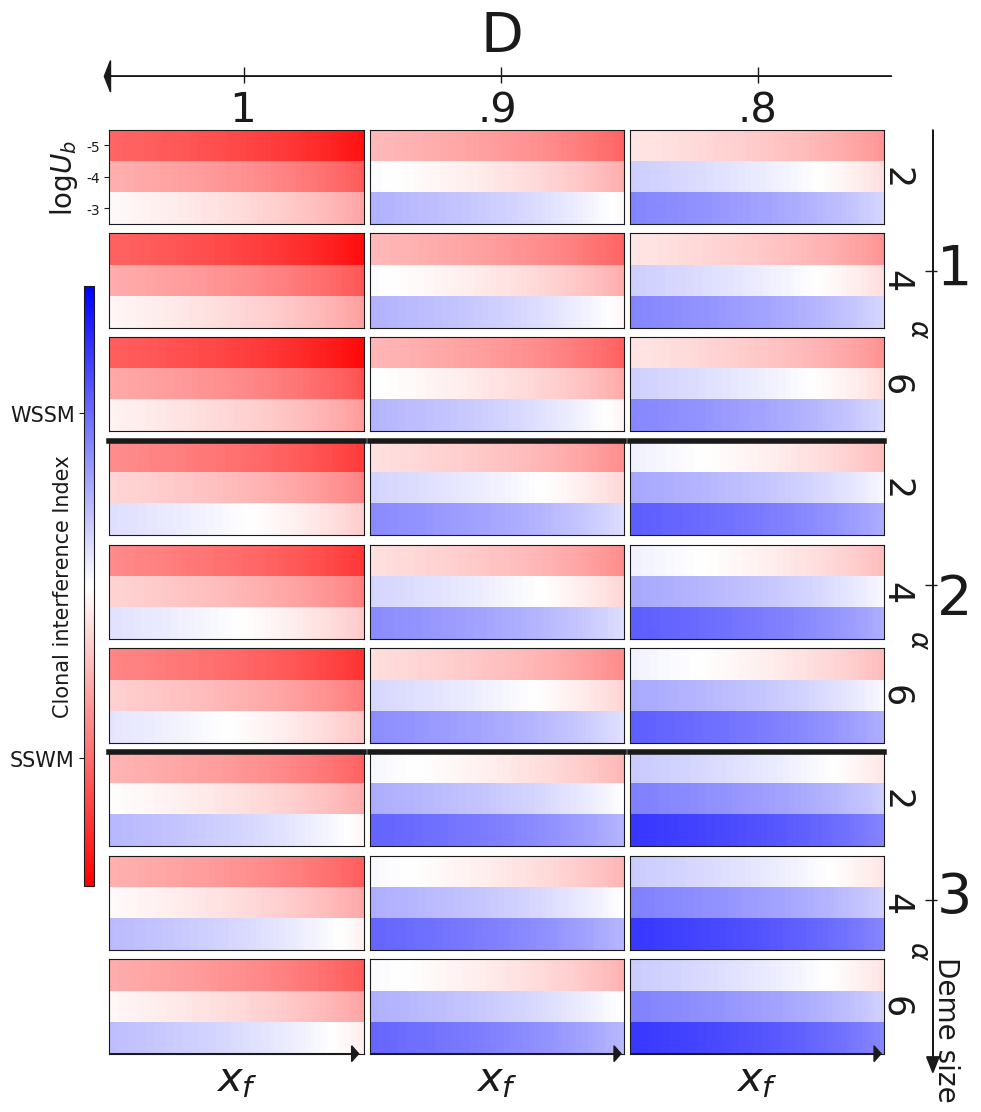

In [3367]:
fig, axs = plt.subplots(9,3,figsize=(10,12))

for ax,l,j,k in zip(axs.flat,9*np.array(range(3)).tolist(),np.array([[3*[i] for i in range(3)]*3 for j in range(3)]).flatten(),np.array([[9*[i] for i in range(3)]]*3).flatten()): 
    #print(l,j,k)
    m = ax.imshow(CIs[k,j,l,:].tolist(),vmin=-4,vmax=4,cmap='bwr_r',aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
cbar_ax = fig.add_axes([0.1, 0.25, 0.01, 0.5])
cbar = fig.colorbar(m, cax=cbar_ax,ticks= [-2.3,2.3])
cbar.set_label('Clonal interference Index', rotation=90,fontsize=15,labelpad=-30)
cbar_ax.set_yticklabels(['SSWM','WSSM'],fontsize=15)
cbar_ax.yaxis.set_ticks_position('left')

    
plt.subplots_adjust(wspace=.02)
plt.subplots_adjust(hspace=.1)



axs[0,0].set_yticks([0,1,2])
axs[0,0].set_yticklabels([-5,-4,-3],fontsize=10)
axs[0,0].set_ylabel(r'$\logU_b$',fontsize=20,rotation=90)


for i in [0,1,2]:
    axs[0+3*i,-1].set_ylabel('2',fontsize=25,labelpad=-180,rotation=270)
    axs[1+3*i,-1].set_ylabel('4',fontsize=25,labelpad=-180,rotation=270)
    axs[2+3*i,-1].set_ylabel('6',fontsize=25,labelpad=-180,rotation=270)

    axs[1+3*i,-2].set_ylabel(r'$\alpha$',fontsize=20,rotation=270,labelpad=50)
    axs[1+3*i,-2].yaxis.set_label_coords(2.1, 0)

axs[0+4*0,-1].set_ylabel('2',fontsize=25,labelpad=-180,rotation=270)

axs[0,0].text(180,-3,'D',fontsize=40)
axs[0,0].set_title(' 1',fontsize=30)
axs[0,1].set_title('.9',fontsize=30)
axs[0,2].set_title('.8',fontsize=30)


ax.text(132,-22,1,fontsize=40)
ax.text(132,-11.5,2,fontsize=40)
ax.text(132,-2,3,fontsize=40)


ax.text(130,.1,'Deme size',fontsize=20,rotation=270)

axs[0,0].arrow(400,-.5,0,29.5,head_width =6,head_length= .5,clip_on=False,color = 'k')
axs[0,0].arrow(396,4,6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(396,14,6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(396,24,6,0,head_width =0,head_length= 0,clip_on=False,color = 'k')


axs[0,0].arrow(380,-2.2,-380,-0,head_width =1,head_length= 3,clip_on=False,color = 'k')
axs[0,0].arrow(65,-2,0,-.5,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(190,-2,0,-.5,head_width =0,head_length= 0,clip_on=False,color = 'k')
axs[0,0].arrow(315,-2,0,-.5,head_width =0,head_length= 0,clip_on=False,color = 'k')


for i in [0,1,2,]:
    axs[-1,i].set_xlabel(r'$x_{f}$',fontsize=30)
    
axs[-1,0].arrow(0,2.5,104,0,head_width=.5,head_length=3,clip_on=False,color = 'k')
axs[-1,1].arrow(0,2.5,105,0,head_width=.5,head_length=3,clip_on=False,color = 'k')
axs[-1,2].arrow(0,2.5,105,0,head_width=.5,head_length=3,clip_on=False,color = 'k')



for i in[0,1,2]:
    for j in range(np.prod(CIs.shape[:2]))[::3][1:]:
        axs[j,i].spines['top'].set_linewidth(4)

plt.savefig('CII_map.pdf')

In [3368]:
np.log(10)

2.302585092994046

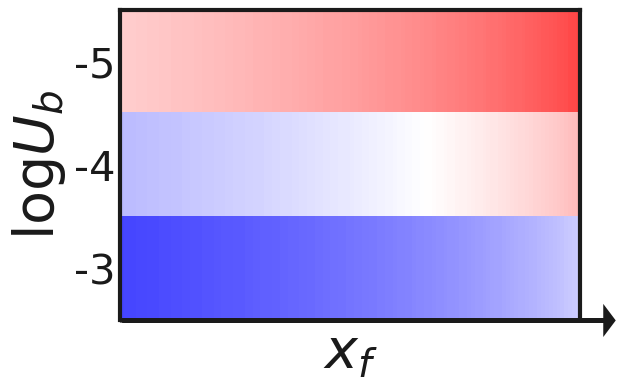

In [3383]:
fig, ax = plt.subplots(figsize=(6,4))


m = ax.imshow(CIs[1,1,1,:].tolist(),vmin=-2.5,vmax=2.5,cmap='bwr_r',aspect='auto')
ax.set_xticks([])




ax.set_yticks([0,1,2,])
ax.set_yticklabels([-5,-4,-3],fontsize=30)
ax.set_ylabel(r'$\logU_b$',fontsize=40)
ax.set_xlabel(r'$x_{f}$',fontsize=40)
ax.arrow(0,2.5,124,0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=3)

ax.tick_params(axis=u'both', which=u'both',length=0)

ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
plt.subplots_adjust(wspace=.05)
plt.subplots_adjust(hspace=.1)
plt.tight_layout()

plt.savefig('CII_inset.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))


m = ax.imshow(CIs[1,0,1,:].tolist(),vmin=-2.5,vmax=2.5,cmap='bwr_r',aspect='auto')
ax.set_xticks([])




ax.set_yticks([0,1,2,])
ax.set_yticklabels([-5,-4,-3],fontsize=30)
ax.set_ylabel(r'$\logU_b$',fontsize=40)
ax.set_xlabel(r'$x_{f}$',fontsize=40)
ax.arrow(0,2.5,124,0,head_width=.2,head_length=2,clip_on=False,color = 'k',lw=3)

ax.tick_params(axis=u'both', which=u'both',length=0)

ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
plt.subplots_adjust(wspace=.05)
plt.subplots_adjust(hspace=.1)
plt.tight_layout()

plt.savefig('CII_inset.pdf')

In [2053]:
K=1*10**4
mu= 10**-3.5
s = .1
rw=.1
alpha=2
D = 1
stand = odeint(standing_wave,[1,-.001],np.linspace(0,R-1,R),args=(D,rw))
p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .001)
L_f = np.where((stand[:,0]*K)>1)[0][-1]

In [2074]:
N = K*sum(stand[:,0][:L_f])
(N*mu)/np.log(N*s)

14.607965421882925

In [2055]:
fix_count = p_surf[:,0][:L_f]*stand[:,0][:L_f]*K*mu
f_e = np.where(fix_count==max(fix_count))[0][0]
calc_est_times =1/max(fix_count)

In [2056]:
calc_fix_times = []
for i in range(L_f):
    ft = ((2*L_f-i-f_e)/ ( 2*((D*rm)**.5))-(2*((D*rw)**.5)))
    calc_fix_times.append(ft)

In [2072]:
calc_est_times

49.34778476150921

In [2058]:
(1/s)*np.log(N*s)

108.19367504865201

In [2059]:
1/(N*mu*s)

0.06327153851969367

In [2060]:
N

499794.65240664256

In [2069]:
np.log(calc_fix_times[-1]/calc_est_times)

-0.6267589989180113

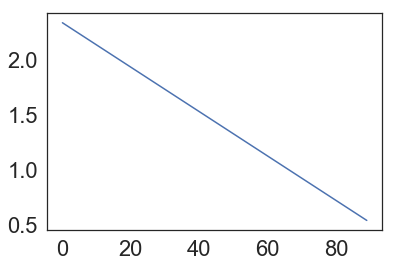

In [2071]:
plt.plot(calc_fix_times/calc_est_times)

Text(0.5,0,'$x_f$')

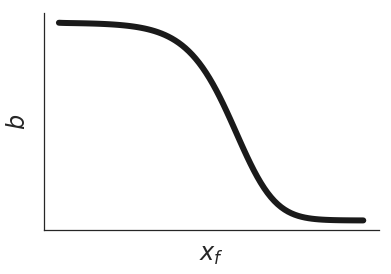

In [2098]:
fig,ax=plt.subplots()
ax.plot(stand[:,0][:L_f],lw=6,color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_ylabel('$b$')
ax.set_xlabel('$x_f$')

In [3106]:
R= 5000
t=np.linspace(0,1000,10000)
D=M_A(.0015,.000035,.0028,1)
K=1*10**4
mu= 10**-3.5
s = .1
rw=.1
alpha=2
D = 1
stand = odeint(standing_wave,[1,-.001],np.linspace(0,R-1,R),args=(D,rw))
p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .001)
L_f = np.where((stand[:,0]*K)>1)[0][-1]
sim_sde_2 = sde_model_solve_2mut(R=R, R_div=1,
                          c=.0015,c_0=.000035,c_1=.0028,
                          delta= 0,I = 0,
                          K_x = 0, K_s = 0,N = .0, H = 0,rw=rw,
                          a = a,mu = mu,
                          b0 = np.exp( -(np.linspace(0,R-1,R)**2)/(2**2)),
                                 s0 = np.full(R,1),t = t,L_f=L_f, K = K )

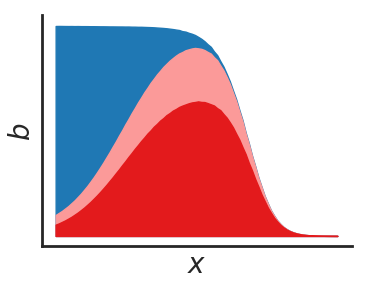

In [3108]:
fig, ax = plt.subplots(figsize=(4,3))

t0 =1800
rng = 200
x = sim_sde_2[t0][0:R]+ sim_sde_2[t0][R:2*R] +sim_sde_2[t0][2*R:3*R]
xm = sim_sde_2[t0][R:2*R] +sim_sde_2[t0][2*R:3*R]
xm2 = sim_sde_2[t0][2*R:3*R]
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_ylabel('$b$',fontsize=20)
ax.set_xlabel('$x$',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

x = x[(x*K)>1]
xm = xm[(xm*K)>1]
xm2 = xm2[(xm2*K)>1]


pal = sns.color_palette("Paired",10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.fill_between(range(L_f),x[-L_f:],color=pal[1])
ax.fill_between(range(L_f),xm[-L_f:],color=pal[4])
ax.fill_between(range(L_f),xm2[-L_f:],color=pal[5])
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig('rng_exp.pdf')

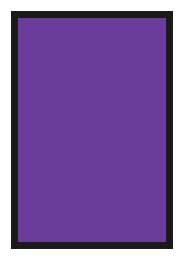

In [2266]:
fig, ax = plt.subplots(figsize=(2,3))




pal = sns.color_palette("Paired",10)

ax.fill_between(range(L_f),1,color=pal[9])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0,L_f-1)
ax.set_ylim(0,1)

for i in ['left','right','bottom','top']:
    ax.spines[i].set_linewidth(5)
plt.savefig('wellmixed.pdf')

In [2155]:
x = sim_sde_2[t0][0:R]+ sim_sde_2[t0][R:2*R] +sim_sde_2[t0][2*R:3*R]

In [2159]:
x = x[(x*K)>1]

In [2164]:
L_f

90

In [2166]:
x

array([9.99825548e-01, 9.99932182e-01, 9.99899936e-01, 9.99983955e-01,
       9.99967944e-01, 1.00000040e+00, 9.99976025e-01, 9.99990595e-01,
       9.99971485e-01, 9.99999442e-01, 9.99999111e-01, 9.99999946e-01,
       1.00000126e+00, 1.00000023e+00, 1.00000804e+00, 1.00000061e+00,
       9.99999749e-01, 1.00000009e+00, 9.99997597e-01, 9.99999933e-01,
       1.00000999e+00, 1.00000084e+00, 1.00001954e+00, 1.00000084e+00,
       9.99999712e-01, 1.00000091e+00, 1.00000068e+00, 1.00000688e+00,
       9.99999867e-01, 9.99999854e-01, 1.00000069e+00, 9.99990722e-01,
       1.00000037e+00, 1.00000050e+00, 9.99996231e-01, 1.00000180e+00,
       9.99999958e-01, 1.00000016e+00, 9.99998497e-01, 1.00000411e+00,
       9.99995363e-01, 1.00000580e+00, 1.00000289e+00, 9.99997109e-01,
       9.99998953e-01, 9.99994988e-01, 9.99999324e-01, 1.00000019e+00,
       9.99992402e-01, 1.00000099e+00, 9.99920051e-01, 9.99998146e-01,
       9.99980665e-01, 1.00000015e+00, 9.99972169e-01, 9.99999897e-01,
      

In [3109]:
R= 500
t=np.linspace(0,1000,10000)
D=M_A(.00272,.000035,.0028,1)
K =1*10**4
a =2.5
mu = 10**-5
rw=.1
stand = odeint(standing_wave,[1,-.001],np.linspace(0,R-1,R),args=(D,rw))
p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .001)
L_f = np.where((stand[:,0]*K)>1)[0][-1]
sim_sde_2 = sde_model_solve_2mut(R=R, R_div=1,
                          c=.00272,c_0=.000035,c_1=.0028,
                          delta= 0,I = 0,
                          K_x = 0, K_s = 0,N = .0, H = 0,rw=rw,
                          a = a,mu = mu,
                          b0 = np.exp( -(np.linspace(0,R-1,R)**2)/(2**2)),
                                 s0 = np.full(R,1),t = t,L_f=L_f, K = K )

In [3110]:
K =1*10**4
a =2.5
mu = 10**-5
rw=.1
D= 1 
stand = odeint(standing_wave,[1,-.001],np.linspace(0,R-1,R),args=(D,rw))
p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .001)
L_f = np.where((stand[:,0]*K)>1)[0][-1]

In [3111]:
fix_count = p_surf[:,0][:L_f]*stand[:,0][:L_f]*K*mu
f_e = np.where(fix_count==max(fix_count))[0][0]
calc_est_times =1/max(fix_count)

In [3112]:
D= 1 
K =1*10**5
rw=.05
R=500
aas = np.linspace(1.2,4.1,50)
mus = np.linspace(10**-8,10**-2,50)

CIIs_bulk= np.zeros((len(aas),len(mus)))
CIIs_tip = np.zeros((len(aas),len(mus)))
CIIs_mix = np.zeros((len(aas),len(mus)))

c1=0
c2=0
for a in aas:
    c1=0
    for mu in mus:

        stand = odeint(standing_wave,[1,-.000000001],np.linspace(0,R-1,R),args=(D,rw))
        p_surf = surf_prob_solve(stand[:,0],rw,rw*a,D, .0001)
        L_f = np.where((stand[:,0]*K)>1)[0][-1]


        fix_count = p_surf[:,0][:L_f]*stand[:,0][:L_f]*K*mu
        f_e = np.where(fix_count==max(fix_count))[0][0]
        calc_est_times =1/max(fix_count)

        calc_fix_times = []
        for i in range(L_f):
            ft = ((2*L_f-i-f_e)/ ( 2*((D*rm)**.5))-(2*((D*rw)**.5)))
            calc_fix_times.append(ft)


        N = sum(stand[:,0][:L_f])*K
        CII_bulk = np.log(calc_fix_times[0]/calc_est_times)

        CII_tip = np.log(calc_fix_times[-1]/calc_est_times)

        CII_mix = np.log(np.log((a-1)*rw*N)*(N *mu) )

        CIIs_bulk[c1,c2]= CII_bulk
        CIIs_tip[c1,c2]=CII_tip
        CIIs_mix[c1,c2]=CII_mix
        
        c1+=1
    c2+=1



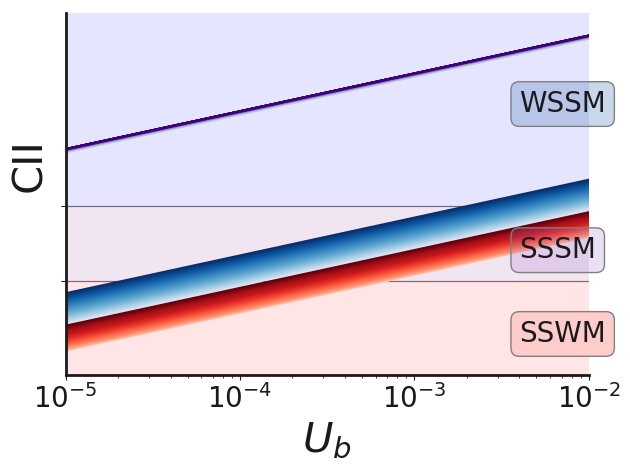

In [3189]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')





fig,ax = plt.subplots()
colors = pl.cm.Purples(np.linspace(.3,1,len(CIIs_mix)))
for i in range(len((CIIs_mix))):
    ax.semilogx(mus,CIIs_mix[:,i],color=colors[i])
    
    
    
colors = pl.cm.Blues(np.linspace(.1,1,25))
for i in range(int(len((CIIs_mix))/2)):
    ax.semilogx(mus,CIIs_bulk[:,i],color=colors[i],alpha=1)
    

#plt.fill_between(range(len(CIIs_mix)),CIIs_bulk[:,-15],CIIs_bulk[:,-1], color=colors[-1],alpha=.3)
    
colors = pl.cm.Reds(np.linspace(.1,1,25))
for i in range(int(len((CIIs_mix))/2)):
    ax.semilogx(mus,CIIs_tip[:,i],color=colors[i],alpha=1)
    
    
ax.set_xlim([10**-6,10**-3])
   
#plt.fill_between(mus,CIIs_tip[:,-15],CIIs_tip[:,-1], color=colors[-1],alpha=.3)
    
ax.set_yticks([-2.3,2.3])
ax.set_yticklabels([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, which='major',color='k',alpha=.5)
ax.set_ylabel('CII',fontsize=30,labelpad=100)
ax.set_xlabel(r'$U_b$',fontsize=30)
ax.text(.0004,-6,'SSWM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(1., 0.8, 0.8)))
ax.text(.0004,-.9,'SSSM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(.6, 0.4, 0.8,.2)))
ax.text(.0004,8,'WSSM',fontsize=20,bbox=dict(boxstyle="round",ec='grey',fc=(.3, 0.5, 0.7,.3)))
ax.yaxis.set_label_coords(-.03,.58)
ax.fill_between(mus,-2.3,-14,color='red',alpha=.1)
ax.fill_between(mus,2.3,-2.3,color='purple',alpha=.1)
ax.fill_between(mus,17,2.3,color='blue',alpha=.1)

#ax.set_xticks([-1,50])
ax.set_xticklabels([r'$10^{-6}$',r'$10^{-5}$',r'$10^{-4}$',r'$10^{-3}$',r'$10^{-2}$'],fontsize=20)


ax.set_ylim([-8,14])

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)







#img2 = plt.imshow([aas], cmap="Reds",vmin=1,vmax=4.5);
#img2.set_visible(False)
#cbar2 = plt.colorbar(img2,orientation="vertical",ticks=[],ticklocation='right');#
#cbar.ax.get_yaxis().labelpad = 
#cbar1.ax.set_ylabel(r'', rotation=270,fontsize=30)

#img = plt.imshow([aas], cmap="Purples",vmin=1,vmax=4.5);
#plt.axis('off')
#plt.grid(False)
#img.set_visible(False)

#cbar = plt.colorbar(img,orientation="vertical",ticks=[1,4],);
#cbar.ax.yaxis.set_ticks_position('left')
#cbar.ax.set_ylabel(r'$\alpha$', rotation=90,fontsize=40,labelpad=-65)
#cbar.ax.tick_params(labelsize=30) 


plt.tight_layout()
plt.savefig('mixvfish.pdf')

/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/nikhilkrishnan/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


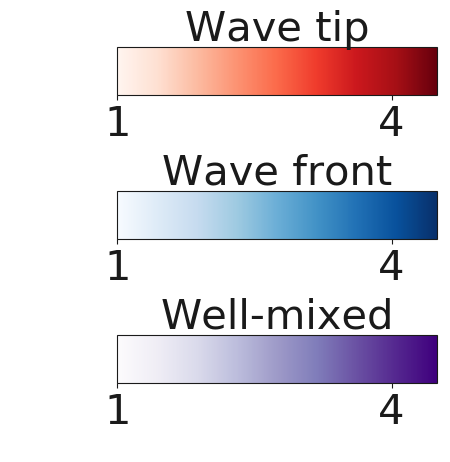

In [3396]:


fig=plt.figure()

ax = fig.add_axes([0, 0, 0.01, 0.01]) 
ax.grid(False)
ax.axis('off')
img = ax.imshow([aas], cmap="Purples",vmin=1,vmax=4.5);
img.set_visible(False)
c_ax1 = fig.add_axes([0.1, 0.1, 0.5, 0.1]) 
cbar = plt.colorbar(img,orientation="horizontal",cax=c_ax1,ticks=[1,4]);
#cbar.ax.yaxis.set_ticks_position('left')
c_ax1.set_ylabel(r'Well-mixed', rotation=0,fontsize=30)
c_ax1.yaxis.set_label_coords(.5, .95)
c_ax1.tick_params(labelsize=30) 



ax1 = fig.add_axes([0, 0, 0.01, 0.01]) 
ax1.grid(False)
ax1.axis('off')
img1 = ax1.imshow([aas], cmap="Blues",vmin=1,vmax=4.5);
img1.set_visible(False)
c_ax2 = fig.add_axes([0.1, 0.4, 0.5, 0.1]) 
cbar2 = plt.colorbar(img1,orientation="horizontal",cax=c_ax2,ticks=[1,4]);
cbar2.ax.yaxis.set_ticks_position('left')
c_ax2.set_ylabel(r'Wave front', rotation=0,fontsize=30)
c_ax2.yaxis.set_label_coords(.5, .95)
c_ax2.tick_params(labelsize=30) 


ax2 = fig.add_axes([0, 0, 0.01, 0.01]) 
ax2.grid(False)
ax2.axis('off')
img2 = ax2.imshow([aas], cmap="Reds",vmin=1,vmax=4.5);
img2.set_visible(False)
c_ax3 = fig.add_axes([0.1, 0.7, 0.5, 0.1]) 
cbar3 = plt.colorbar(img2,orientation="horizontal",cax=c_ax3,ticks=[1,4]);
cbar3.ax.yaxis.set_ticks_position('left')
c_ax3.set_ylabel(r'Wave tip', rotation=0,fontsize=30)
c_ax3.yaxis.set_label_coords(.5, .95)
c_ax3.tick_params(labelsize=30) 





#img1 = plt.imshow([aas][0:2], cmap="Blues",vmin=1,vmax=4.5);
#img1.set_visible(False)
#cbar1 = plt.colorbar(img1,orientation="vertical",aspect=3,ticks=[]);#
#cbar.ax.get_yaxis().labelpad = 
#cbar1.ax.set_ylabel(r'', rotation=270,fontsize=30)

#img2 = plt.imshow([aas], cmap="Reds",vmin=1,vmax=4.5);
#img2.set_visible(False)
#cbar2 = plt.colorbar(img2,orientation="vertical",aspect=3,ticks=[],ticklocation='right');#
#cbar.ax.get_yaxis().labelpad = 
#cbar1.ax.set_ylabel(r'', rotation=270,fontsize=30)


#img = plt.imshow([aas], cmap="Purples",vmin=1,vmax=4.5);
#plt.axis('off')
#plt.grid(False)
#img.set_visible(False)

#cbar = plt.colorbar(img,orientation="vertical",aspect=3,ticks=[1,4],);
#cbar.ax.yaxis.set_ticks_position('left')
#cbar.ax.set_ylabel(r'$\alpha$', rotation=90,fontsize=40,labelpad=5)
#cbar.ax.tick_params(labelsize=30) 


#img.set_visible(False)
#img1.set_visible(False)
#img2.set_visible(False)
#plt.tight_layout()
plt.savefig('bars.pdf')


In [2487]:
np.linspace(10**-6,10**-3-10**-4,30)

array([1.00e-06, 3.20e-05, 6.30e-05, 9.40e-05, 1.25e-04, 1.56e-04,
       1.87e-04, 2.18e-04, 2.49e-04, 2.80e-04, 3.11e-04, 3.42e-04,
       3.73e-04, 4.04e-04, 4.35e-04, 4.66e-04, 4.97e-04, 5.28e-04,
       5.59e-04, 5.90e-04, 6.21e-04, 6.52e-04, 6.83e-04, 7.14e-04,
       7.45e-04, 7.76e-04, 8.07e-04, 8.38e-04, 8.69e-04, 9.00e-04])

In [2639]:
len(CIIs_mix)/2

15.0

In [2631]:

for i in range(int(len((CIIs_mix))/2)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
